# Running pfNMF on Marjanovic sample Kras30 using Kras 12
To estimates the aplicability of GEPs from the Kras sample at 12 weeks (K12) on the cells from Kras 30 weeks (K30), we use the K12 GEPs readjusted to the jointly highly variable genes (jHVGs) to decompose the K30 dataset using the partially fixed NMF algorithm (pfnmf)

steps:
1.  Loading the data
2.  Finding jointly highly variable genes
3.  Ruuning NNLS to get the K12 GEPs on the jHVGs
4.  Decomposing the K30 dataset de-novo at the same rank as K12
5.  Decomposing the K30 dataset using pfnmf with 0, 1, 2, 3 additional novel programs
6.  Evaluating the usage patterns of the different decompositions
7. 

## Imports and loading data

In [ ]:
%%time
%load_ext autoreload
%autoreload 2

import sys
import os

from urllib.request import urlretrieve

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.decomposition import _nmf as sknmf
from scipy.stats import rankdata
from scipy.cluster import hierarchy

from gepdynamics import _utils
from gepdynamics import _constants
from gepdynamics import cnmf
from gepdynamics import pfnmf

# Move to the project's home directory, as defined in _constants
_utils.cd_proj_home()
print(os.getcwd())

/cs/labs/mornitzan/yotamcon/gep-dynamics
CPU times: user 3.54 s, sys: 1.55 s, total: 5.09 s
Wall time: 1min 19s


In [ ]:
import torch
assert torch.cuda.is_available()
device = 'cuda'

/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


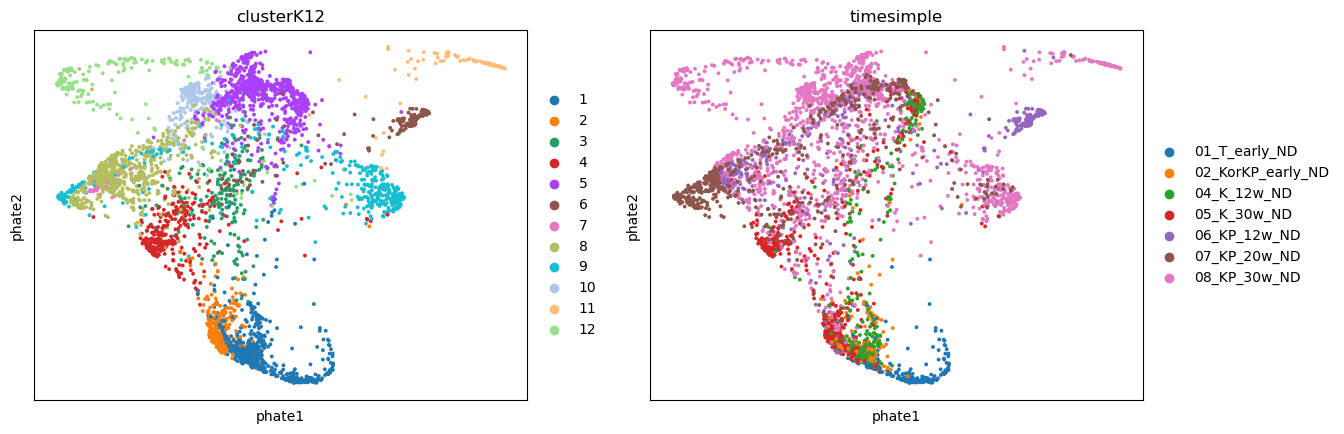

AnnData object with n_obs × n_vars = 3891 × 30999
    obs: 'plateID', 'mouseID', 'timesimple', 'typeID', 'clusterK12', 'n_counts', 'n_genes'
    var: 'ensgID', 'geneSymbol', 'length', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'timesimple_colors', 'clusterK12_colors'
    obsm: 'X_phate', 'X_tsne'

In [ ]:
results_dir = _utils.set_dir('results')
notebook_dir = _utils.set_dir(results_dir.joinpath('marjanovic_k12_k30_pfnmf'))
orig_adata_path = results_dir.joinpath('marjanovic_mmLungPlate.h5ad')
split_adatas_dir = _utils.set_dir(results_dir.joinpath('marjanovic_mmLungPlate_split'))

adata = sc.read(orig_adata_path)
sc.external.pl.phate(adata, color=['clusterK12', 'timesimple'])
adata

In [ ]:
k_12 = sc.read_h5ad(split_adatas_dir.joinpath('04_K_12w_ND_GEPs.h5ad'))
k_12

AnnData object with n_obs × n_vars = 455 × 30999
    obs: 'plateID', 'mouseID', 'timesimple', 'typeID', 'clusterK12', 'n_counts', 'n_genes'
    var: 'ensgID', 'geneSymbol', 'length', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'clusterK12_colors', 'cnmf_params', 'hvg', 'name', 'sname', 'timesimple_colors'
    obsm: 'X_phate', 'X_tsne', 'row_colors', 'usages', 'usages_norm'
    varm: 'usage_coefs'

In [ ]:
k_30 = sc.read_h5ad(split_adatas_dir.joinpath('05_K_30w_ND_GEPs.h5ad'))
k_30

AnnData object with n_obs × n_vars = 505 × 30999
    obs: 'plateID', 'mouseID', 'timesimple', 'typeID', 'clusterK12', 'n_counts', 'n_genes'
    var: 'ensgID', 'geneSymbol', 'length', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'clusterK12_colors', 'cnmf_params', 'hvg', 'name', 'sname', 'timesimple_colors'
    obsm: 'X_phate', 'X_tsne', 'row_colors', 'usages', 'usages_norm'
    varm: 'usage_coefs'

## Running pfNMF on K30 using the K12 GEPs

### Preparing K12 and K30 data on joint highly variable genes (jHVGs)


In [ ]:
var_subset = (k_12.var.n_cells >= 5) & (k_30.var.n_cells >= 5)
obs_subset = adata.obs.timesimple.isin([k_12.uns['name'], k_30.uns['name']])

joint_K12_K30_var = sc.pp.highly_variable_genes(
    adata[obs_subset, var_subset], flavor='seurat_v3',
    n_top_genes=_constants.NUMBER_HVG, inplace=False)
joint_K12_K30_var

/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


,means,variances,highly_variable_rank,variances_norm,highly_variable
geneID,,,,,
ENSMUSG00000000001.4_Gnai3,194.888542,5.199244e+04,NaN,0.979725,False
ENSMUSG00000000028.14_Cdc45,5.904417,1.503283e+03,1388.0,2.168086,True
ENSMUSG00000000056.7_Narf,27.791667,4.079177e+03,NaN,0.933303,False
ENSMUSG00000000058.6_Cav2,95.040625,2.757632e+04,NaN,1.421634,False
ENSMUSG00000000078.7_Klf6,206.710417,2.356955e+05,106.0,3.823077,True
...,...,...,...,...,...
ENSMUSG00000114942.1_Lats2,2.674948,2.773830e+02,NaN,1.155601,False
ENSMUSG00000114951.1_AC238811.4,0.074979,2.453808e-01,NaN,0.671681,False
ENSMUSG00000114960.1_AC115289.2,0.161219,1.055823e+01,1951.0,2.026982,True


In [ ]:
print("Selecting 2000 joint HVGs, intersection with K12 HVGS is "
      f"{np.sum(joint_K12_K30_var.highly_variable & k_12.var.highly_variable)}"
      ", and with K30 is "
      f"{np.sum(joint_K12_K30_var.highly_variable & k_30.var.highly_variable)}")
joint_K12_K30_HVG = joint_K12_K30_var[joint_K12_K30_var.highly_variable].index

Selecting 2000 joint HVGs, intersection with K12 HVGS is 881, and with K30 is 811


In [ ]:
# Variance normalized version of K12 data on the jHVGs
X12 = sc.pp.scale(k_12[:, joint_K12_K30_HVG].X.toarray(), zero_center=False)
print(f'X12.shape = {X12.shape}')
X12[:4, :4]

X12.shape = (455, 2000)


array([[0.        , 0.01119922, 0.        , 0.        ],
       [0.        , 0.24478301, 0.        , 0.        ],
       [0.        , 0.9135366 , 0.        , 0.00701734],
       [0.        , 0.        , 0.        , 0.        ]], dtype=float32)

In [ ]:
# Variance normalized version of K30 data on the jHVGs
X30 = sc.pp.scale(k_30[:, joint_K12_K30_HVG].X.toarray(), zero_center=False)
print(f'X30.shape = {X30.shape}')
X30[:4, :4]

X30.shape = (505, 2000)


array([[1.8623625 , 0.06579945, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.33265278, 0.        , 0.        ]], dtype=float32)

### Running NNLS to get K12 GEPs (geps12) on jHVGs

In [ ]:
#Parameters
beta_loss = 'kullback-leibler'
max_iter = 500

In [ ]:
100 * k_12.obsm['usages_norm'].sum(axis=0) / k_12.n_obs

array([26.991241 , 43.953407 , 12.164866 ,  6.721589 ,  2.9566545,
        7.2122273], dtype=float32)

In [ ]:
# Working in the transposed notation to get the programs: X.T ~ H.T @ W.T

nmf_kwargs={'H': k_12.obsm['usages'].T.copy(),
            'update_H': False,
            'tol': _constants.NMF_TOLERANCE,
            'n_iter': max_iter,
            'beta_loss': beta_loss
           }

tens = torch.tensor(X12.T).to(device)

W, H, n_iter = cnmf.nmf_torch(X12.T, nmf_kwargs, tens, verbose=True)
print(f'Error per sample = {(sknmf._beta_divergence(X12.T, W, H, beta_loss) / k_12.n_obs): .3e}')

del tens

geps12 = W.T
geps12.shape

beta 1 loss = 304212.53125, # iterations was 40
Error per sample =  6.686e+02


(6, 2000)

### Decomposing K30 de-novo with same rank as geps12 (on jHVGs)

In [ ]:
pfnmf_results = {}
rank_k12 = geps12.shape[0]

In [ ]:
%%script --no-raise-error false

nmf_kwargs={
    'n_components': rank_k12,
    'tol': _constants.NMF_TOLERANCE,
    'n_iter': max_iter,
    'beta_loss': beta_loss
   }

tens = torch.tensor(X30).to(device)

W, H, n_iter = cnmf.nmf_torch(X30, nmf_kwargs, tens, verbose=True)

final_loss = sknmf._beta_divergence(X30, W, H, beta_loss)
print(f'Error per sample = {(final_loss / k_30.n_obs): .3e}')

pfnmf_results['de_novo'] = {'W': W, 'H': H, 'n_iter': n_iter, 'final_loss': final_loss}

del tens

### Decomposing K30 with geps12 and no additional programs

In [ ]:
%%script --no-raise-error false

#  x30 ~ W @ geps12

nmf_kwargs={'H': geps12.copy(),
            'update_H': False,
            'tol': _constants.NMF_TOLERANCE,
            'n_iter': max_iter,
            'beta_loss': beta_loss
           }

tens = torch.tensor(X30).to(device)

W, H, n_iter = cnmf.nmf_torch(X30, nmf_kwargs, tens, verbose=True)

final_loss = sknmf._beta_divergence(X30, W, H, beta_loss)
print(f'Error per sample = {(final_loss / k_30.n_obs): .3e}')

pfnmf_results['k12'] = {'W': W, 'H': H, 'n_iter': n_iter, 'final_loss': final_loss}

del tens

### Decomposing K30 with geps12 and additional programs

In [ ]:
%%script --no-raise-error false

# pfnmf is written for constant W_1, so we will transpose as needed:
# x30 ~ W_1 @ geps12 + W_2 @ H_2  <--> x30.T ~ geps12.T @ W_1.T + H_2.T @ W_2.T

for added_rank in range(1, 5):
    print(f"Working on added rank = {added_rank}")
    
    best_loss = np.infty
    
    for repeat in range(20): 
        w1, h1, w2, h2, n_iter = pfnmf.pfnmf(X30.T, geps12.T, rank_2=added_rank, beta_loss=beta_loss,
            tol=_constants.NMF_TOLERANCE, max_iter=max_iter, verbose=False)

        final_loss = pfnmf.calc_beta_divergence(X30.T, w1, w2, h1, h2, beta_loss)
        
        if final_loss <= best_loss:
            best_loss = final_loss
            pfnmf_results[f'k12e{added_rank}'] = {'w1': w1, 'h1': h1, 'w2': w2, 'h2': h2, 'n_iter': n_iter, 'final_loss': final_loss}

            print(f"repeat {repeat}, after {n_iter} iterations reached {final_loss: .4e}"
                 f", per sample loss = {(final_loss / k_30.n_obs): .3e}")

In [ ]:
%%script --no-raise-error false

np.savez_compressed(results_dir.joinpath('marjanovic_k12_k30_pfnmf.npz'), pfnmf_results=pfnmf_results)

In [ ]:
loaded = np.load(results_dir.joinpath('marjanovic_k12_k30_pfnmf.npz'), allow_pickle=True)
print([key for key in loaded.keys()])

['pfnmf_results']


In [ ]:
pfnmf_results = loaded['pfnmf_results'].item()

## Evaluating the added programs

### Preparing plotting parameters

In [ ]:
columns_k12 = [f'k12.p{i}' for i in range(geps12.shape[0])]
sname = k_30.uns["sname"]

coloring_scheme = {'de_novo': '#d62728', 'k12': '#2ca02c', 'k12e1': 'limegreen', 'k12e2': 'yellow', 'k12e3': 'orange', 'k12e4': 'chocolate'}

for key in pfnmf_results.keys():
    print(f"{key}\t{pfnmf_results[key]['final_loss'] / 505: .0f}")

de_novo	 651
k12	 762
k12e1	 729
k12e2	 707
k12e3	 687
k12e4	 668


In [ ]:
for dict_key, short_name in [('de_novo', 'k30'), ('k12', 'k12')]:
    res_dict = pfnmf_results[dict_key]
    
    res_dict['rank'] = rank_k12
    
    res_dict['norm_usage'] = res_dict['W'] / \
        np.linalg.norm(res_dict['W'], 1, axis=1, keepdims=True)
    
    res_dict['prog_percent'] = res_dict['norm_usage'].sum(axis=0) * 100 / k_30.n_obs

    res_dict['prog_name'] = [f'{short_name}.p{i}' for i in range(rank_k12)]
    
    res_dict['prog_label_2l'] = [name + f'\n({res_dict["prog_percent"][i]: 0.1f}%)' for i, name in enumerate(res_dict['prog_name'])]
    res_dict['prog_label_1l'] = [name + f' ({res_dict["prog_percent"][i]: 0.1f}%)' for i, name in enumerate(res_dict['prog_name'])]   

In [ ]:
for index, dict_key in enumerate(['k12e1', 'k12e2', 'k12e3', 'k12e4']):
    added_rank = index + 1
    
    res_dict = pfnmf_results[dict_key]
    
    res_dict['rank'] = rank_k12 + added_rank
    
    usages = np.concatenate([res_dict['h1'], res_dict['h2']], axis=0).T
    
    res_dict['norm_usage'] = usages / np.linalg.norm(usages, 1, axis=1, keepdims=True)
    
    res_dict['prog_percent'] = res_dict['norm_usage'].sum(axis=0) * 100 / k_30.n_obs

    res_dict['prog_name'] = [f'k12e{added_rank}.p{i}' for i in range(rank_k12)]
    res_dict['prog_name'].extend([f'k12e{added_rank}.e{i}' for i in range(added_rank)])
    
    res_dict['prog_label_2l'] = [name + f'\n({res_dict["prog_percent"][i]: 0.1f}%)' for i, name in enumerate(res_dict['prog_name'])]
    res_dict['prog_label_1l'] = [name + f' ({res_dict["prog_percent"][i]: 0.1f}%)' for i, name in enumerate(res_dict['prog_name'])]   

### usages clustermaps

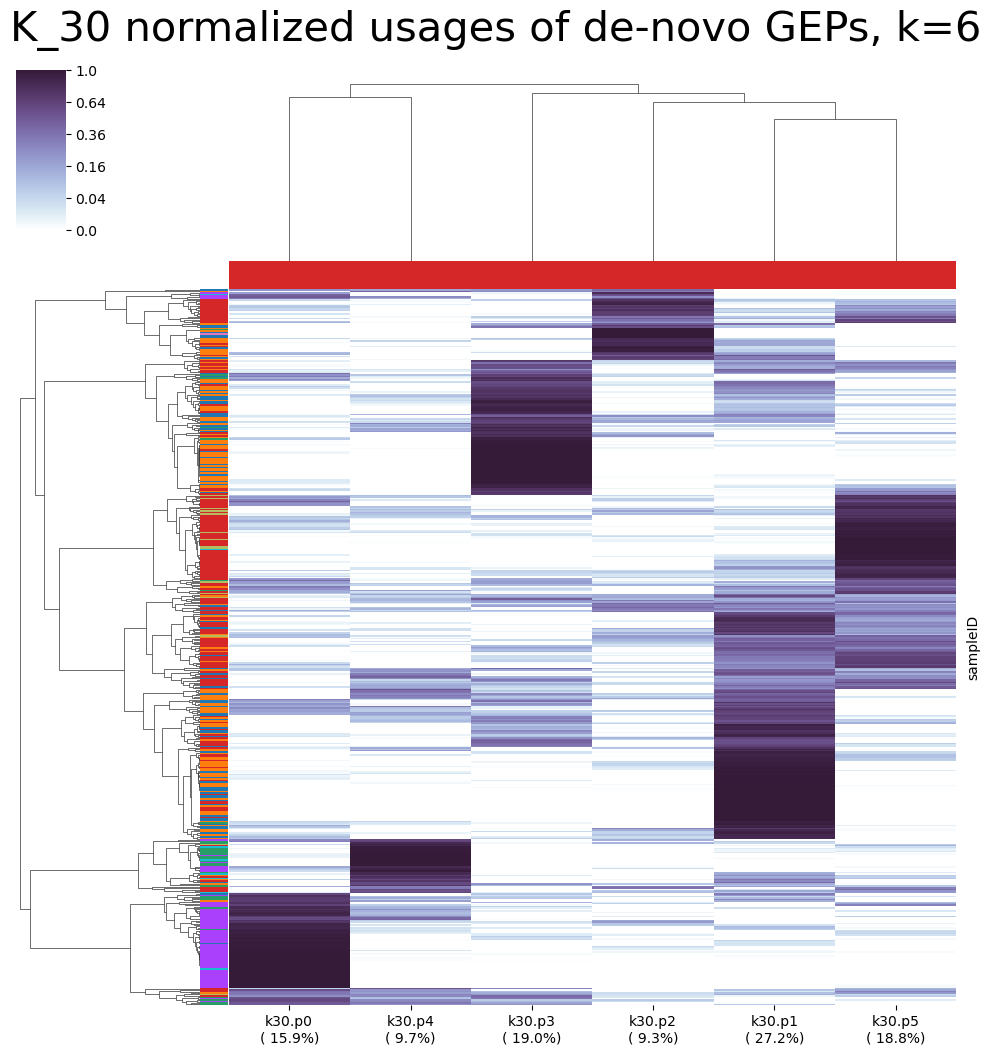

In [ ]:
dict_key = 'de_novo'
res_dict = pfnmf_results[dict_key]

title = f'K_30 normalized usages of de-novo GEPs, k={rank_k12}'

un_sns = _utils.plot_usages_norm_clustermaps(k_30, normalized_usages=res_dict['norm_usage'],
    columns=res_dict['prog_label_2l'], title=title, show=True, sns_clustermap_params={'col_colors': [coloring_scheme[dict_key]] * res_dict['rank']})

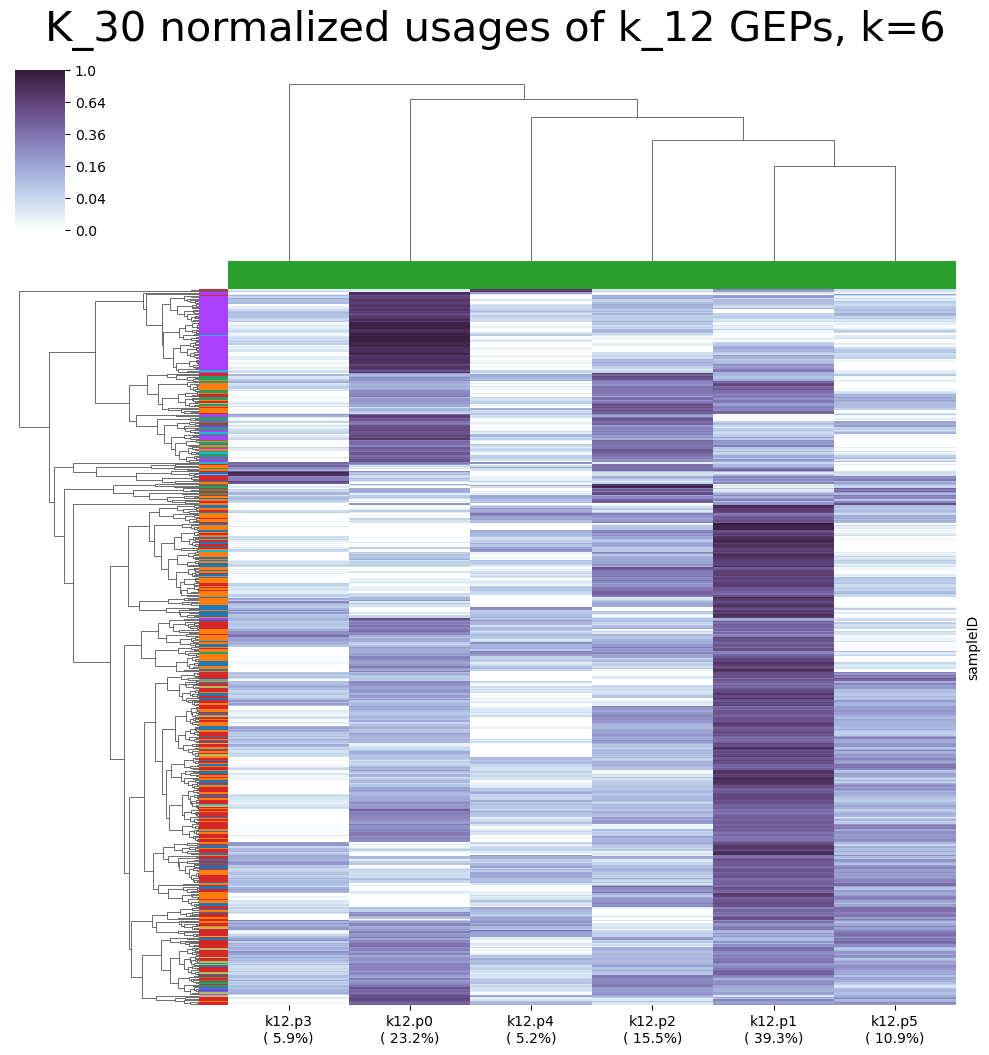

In [ ]:
dict_key = 'k12'
res_dict = pfnmf_results[dict_key]

title = f'K_30 normalized usages of k_12 GEPs, k={rank_k12}'

un_sns = _utils.plot_usages_norm_clustermaps(k_30, normalized_usages=res_dict['norm_usage'],
    columns=res_dict['prog_label_2l'], title=title, show=True, sns_clustermap_params={'col_colors': [coloring_scheme[dict_key]] * res_dict['rank']})

Creating expanded usages DataFrame for added rank 1

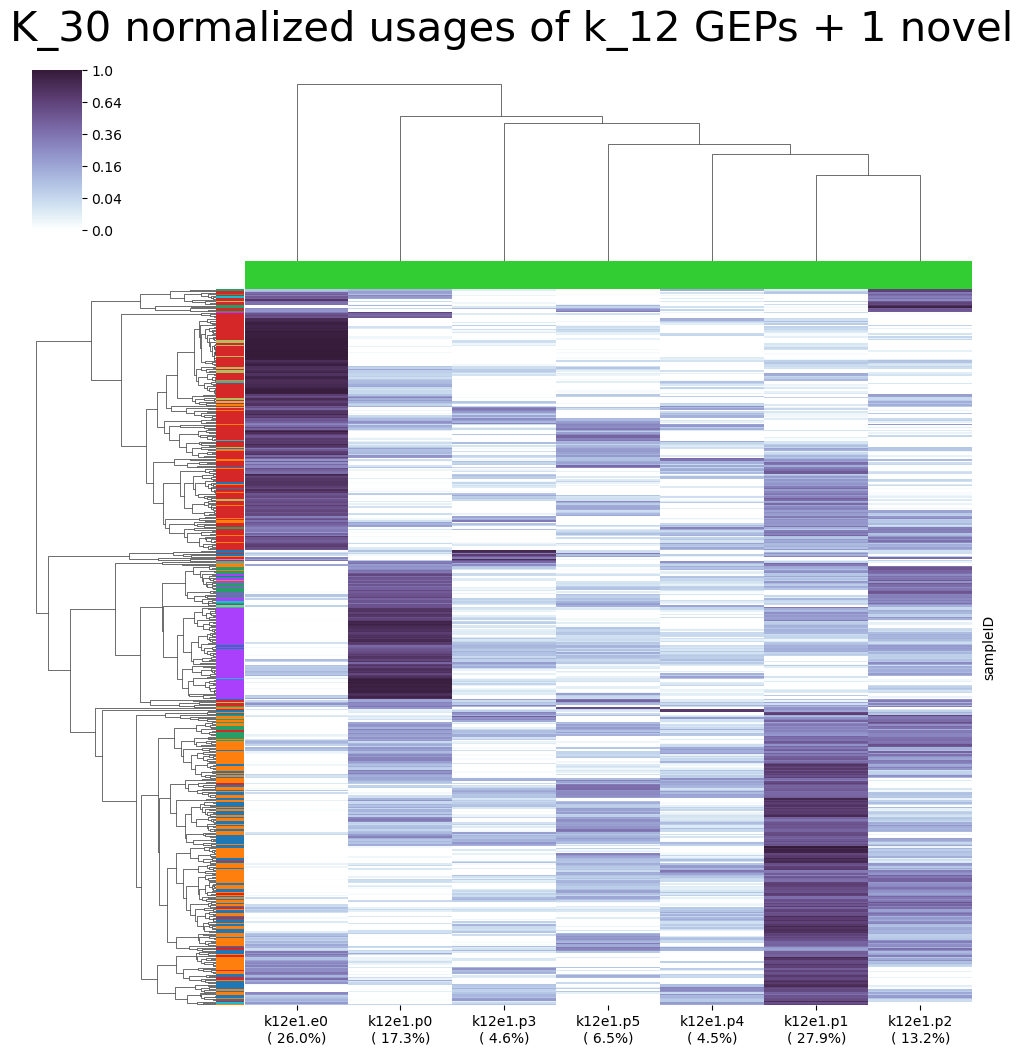

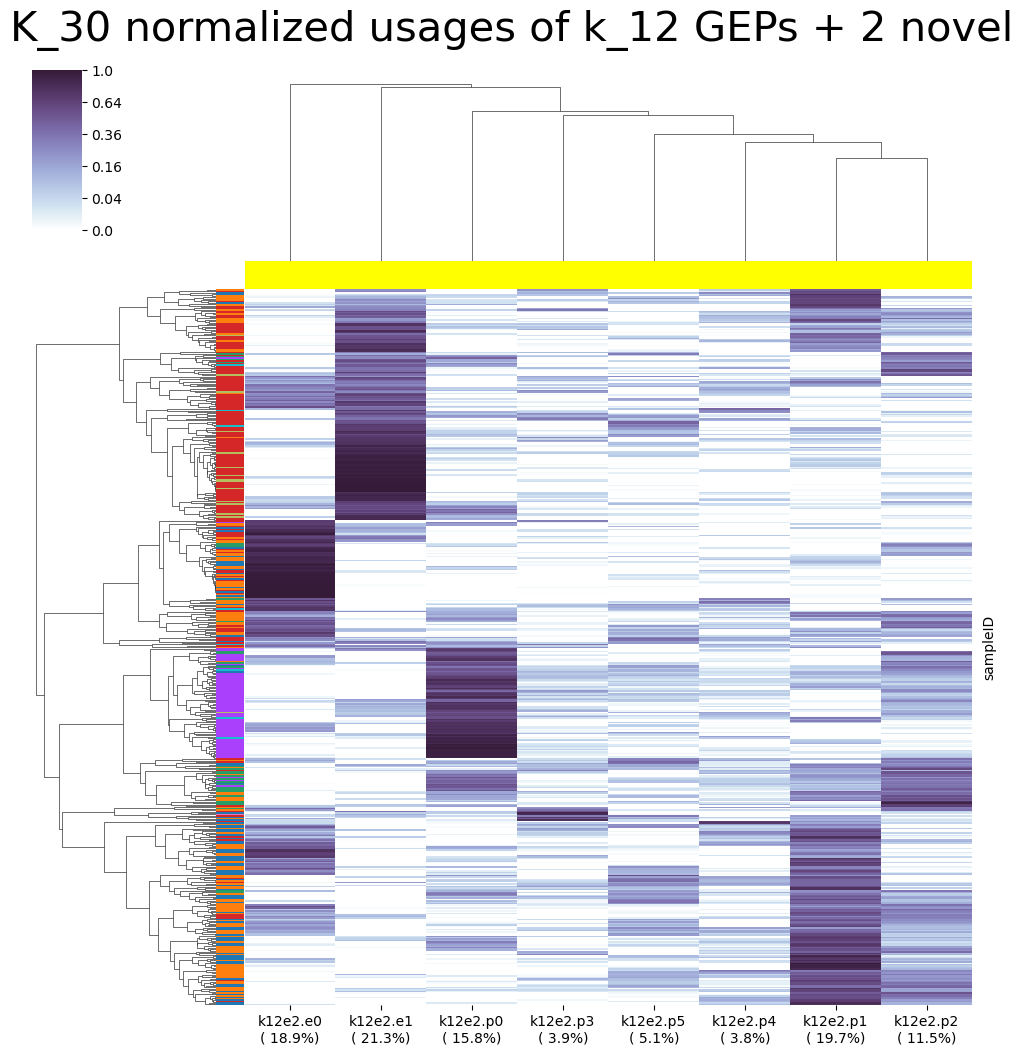

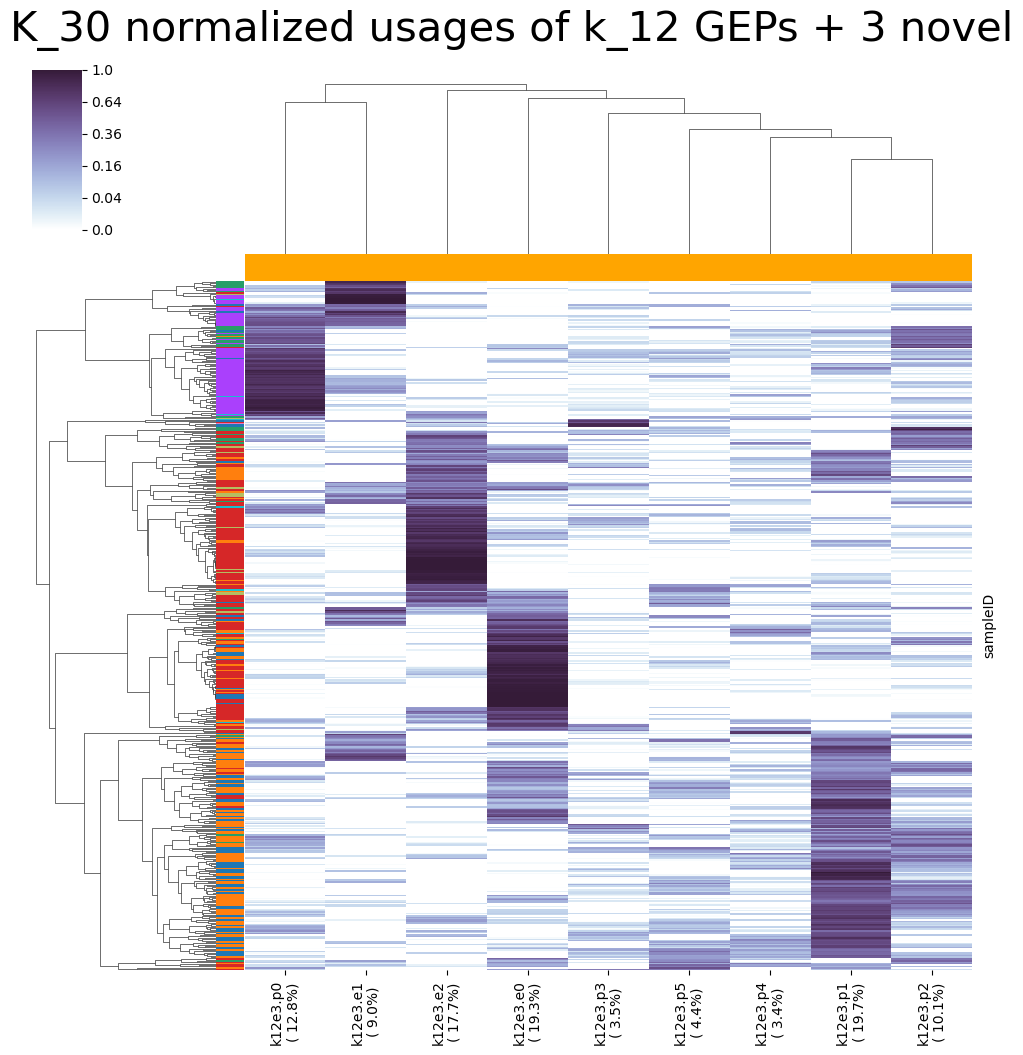

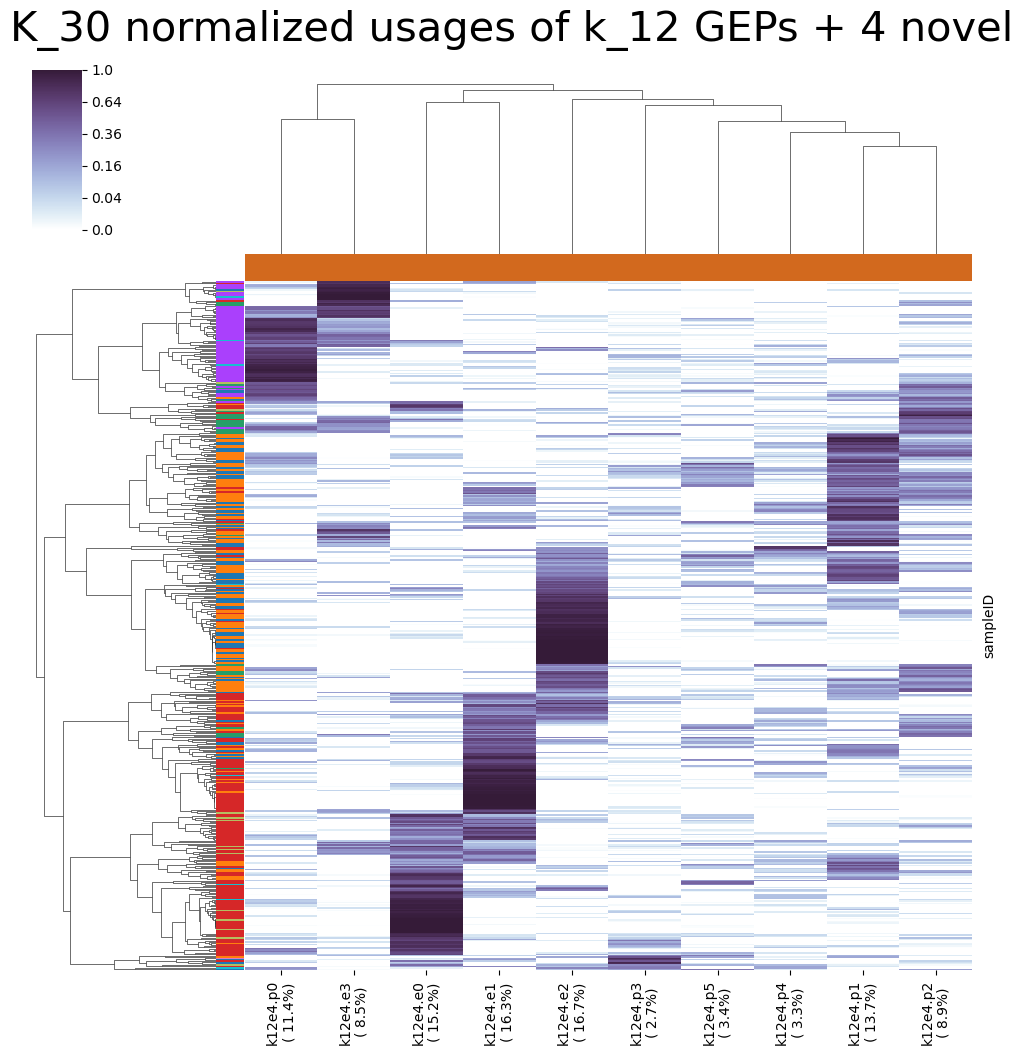

In [ ]:
for dict_key in ['k12e1', 'k12e2', 'k12e3', 'k12e4']:
    res_dict = pfnmf_results[dict_key]
    
    title = f'K_30 normalized usages of k_12 GEPs + {res_dict["rank"] - rank_k12} novel'
    
    un_sns = _utils.plot_usages_norm_clustermaps(k_30, normalized_usages=res_dict['norm_usage'],
        columns=res_dict['prog_label_2l'], title=title, show=True, sns_clustermap_params={'col_colors': [coloring_scheme[dict_key]] * res_dict['rank']})

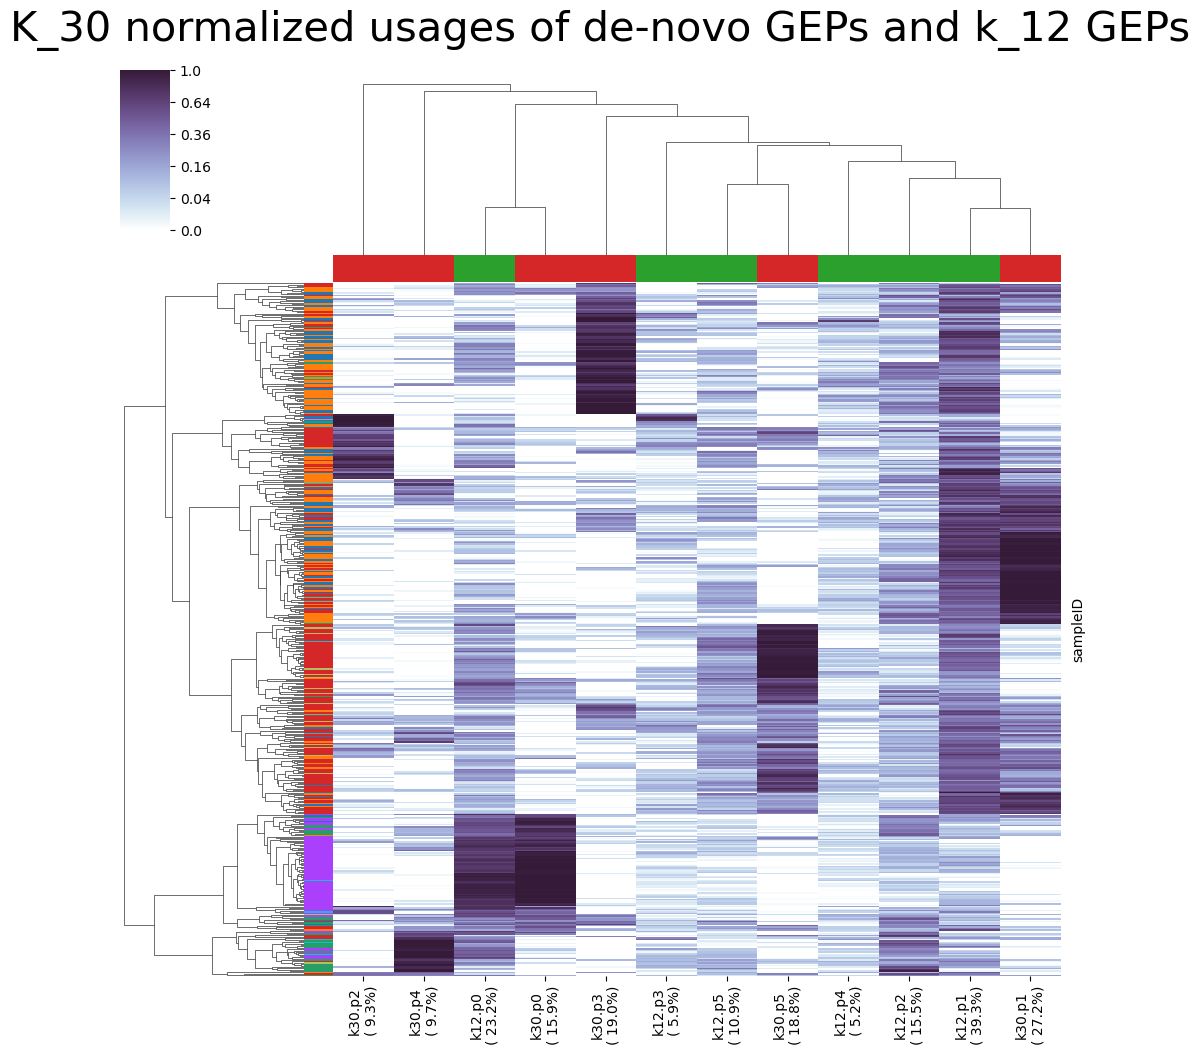

In [ ]:
title = f'K_30 normalized usages of de-novo GEPs and k_12 GEPs'

dict_key0 = 'k12'
res_dict0 = pfnmf_results[dict_key0]

dict_key1 = 'de_novo'
res_dict1 = pfnmf_results[dict_key1]

joint_usages = np.concatenate([res_dict0['norm_usage'], res_dict1['norm_usage']], axis=1)

joint_labels = res_dict0['prog_label_2l'] + res_dict1['prog_label_2l']

joint_colors = [coloring_scheme[dict_key0]] * res_dict0['rank'] + [coloring_scheme[dict_key1]] * res_dict1['rank']

un_sns = _utils.plot_usages_norm_clustermaps(k_30, normalized_usages=joint_usages, columns=joint_labels,
                                             title=title, show=True, sns_clustermap_params={'col_colors': joint_colors})

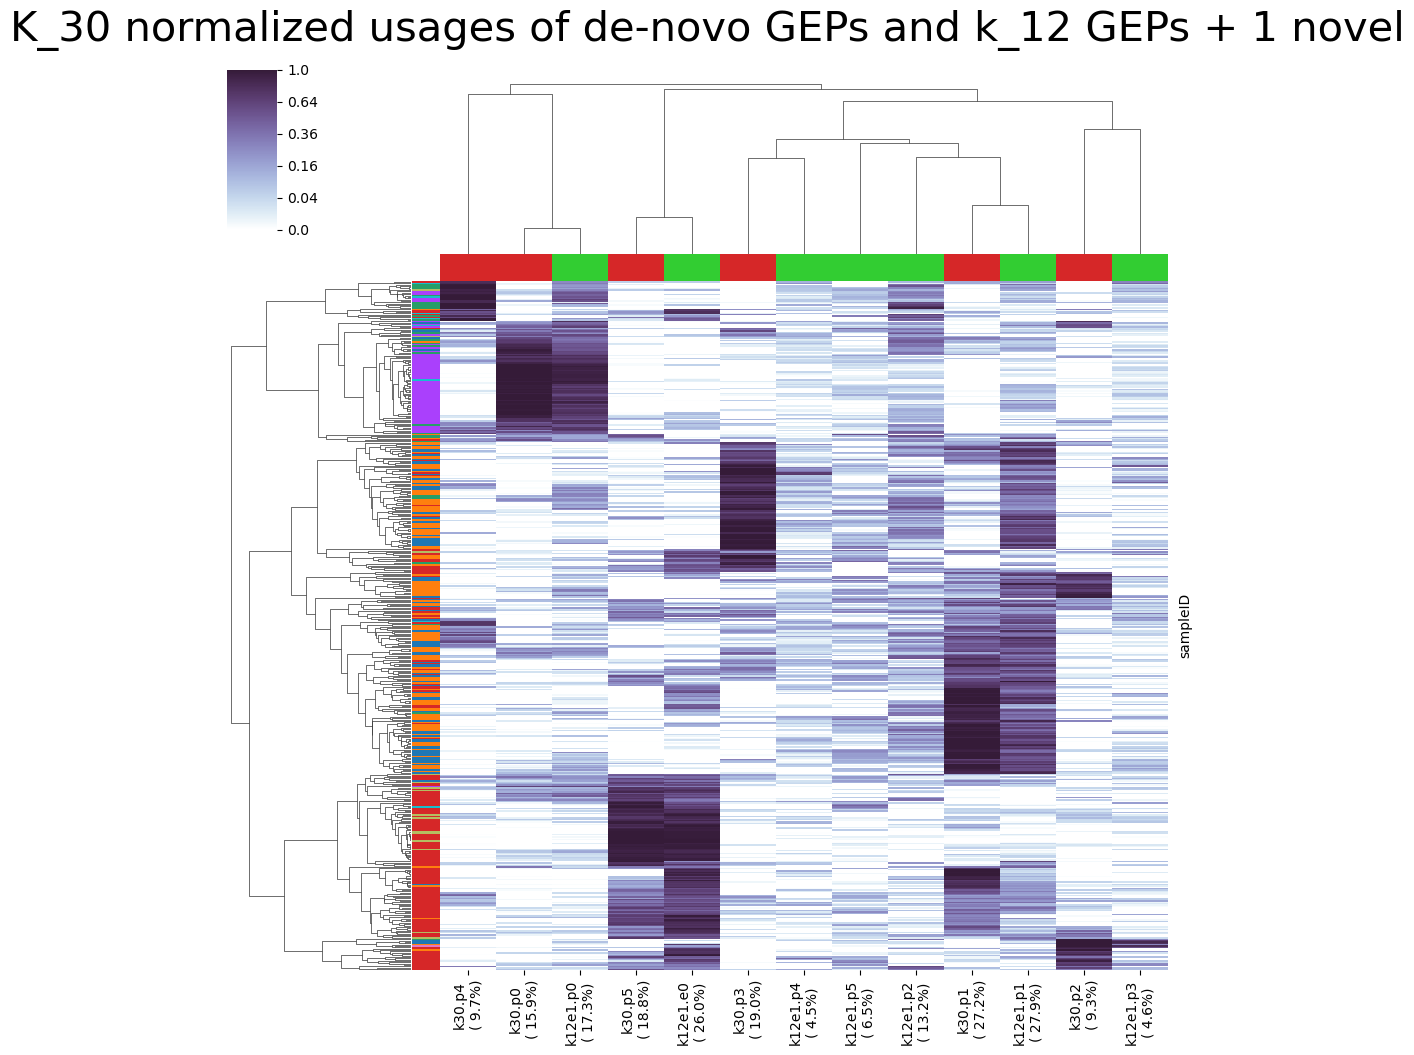

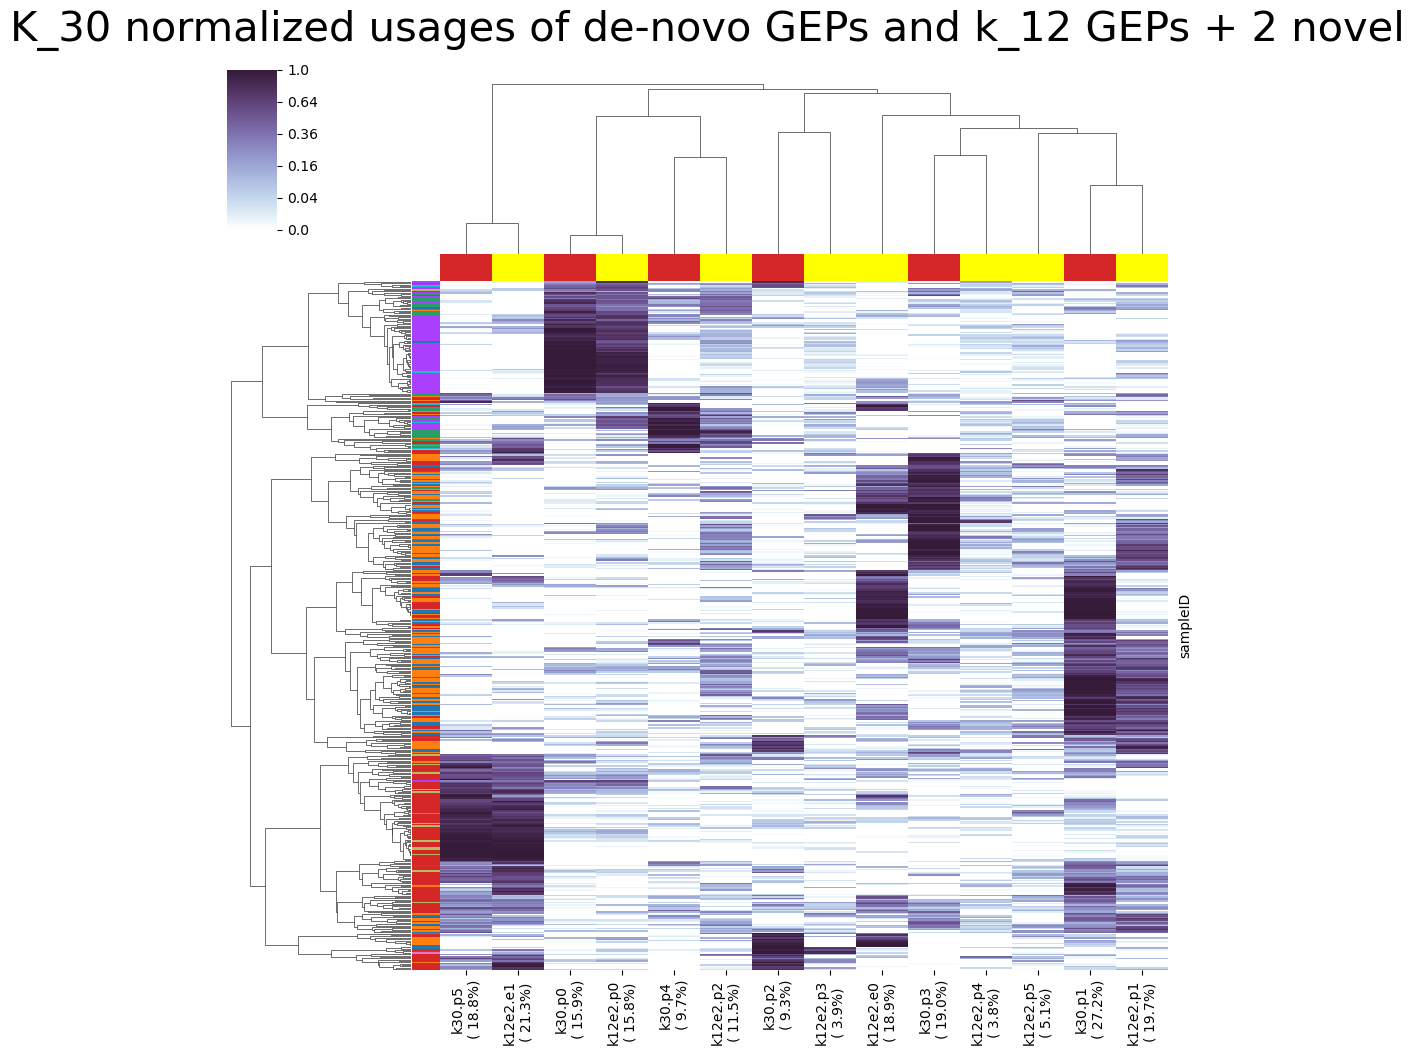

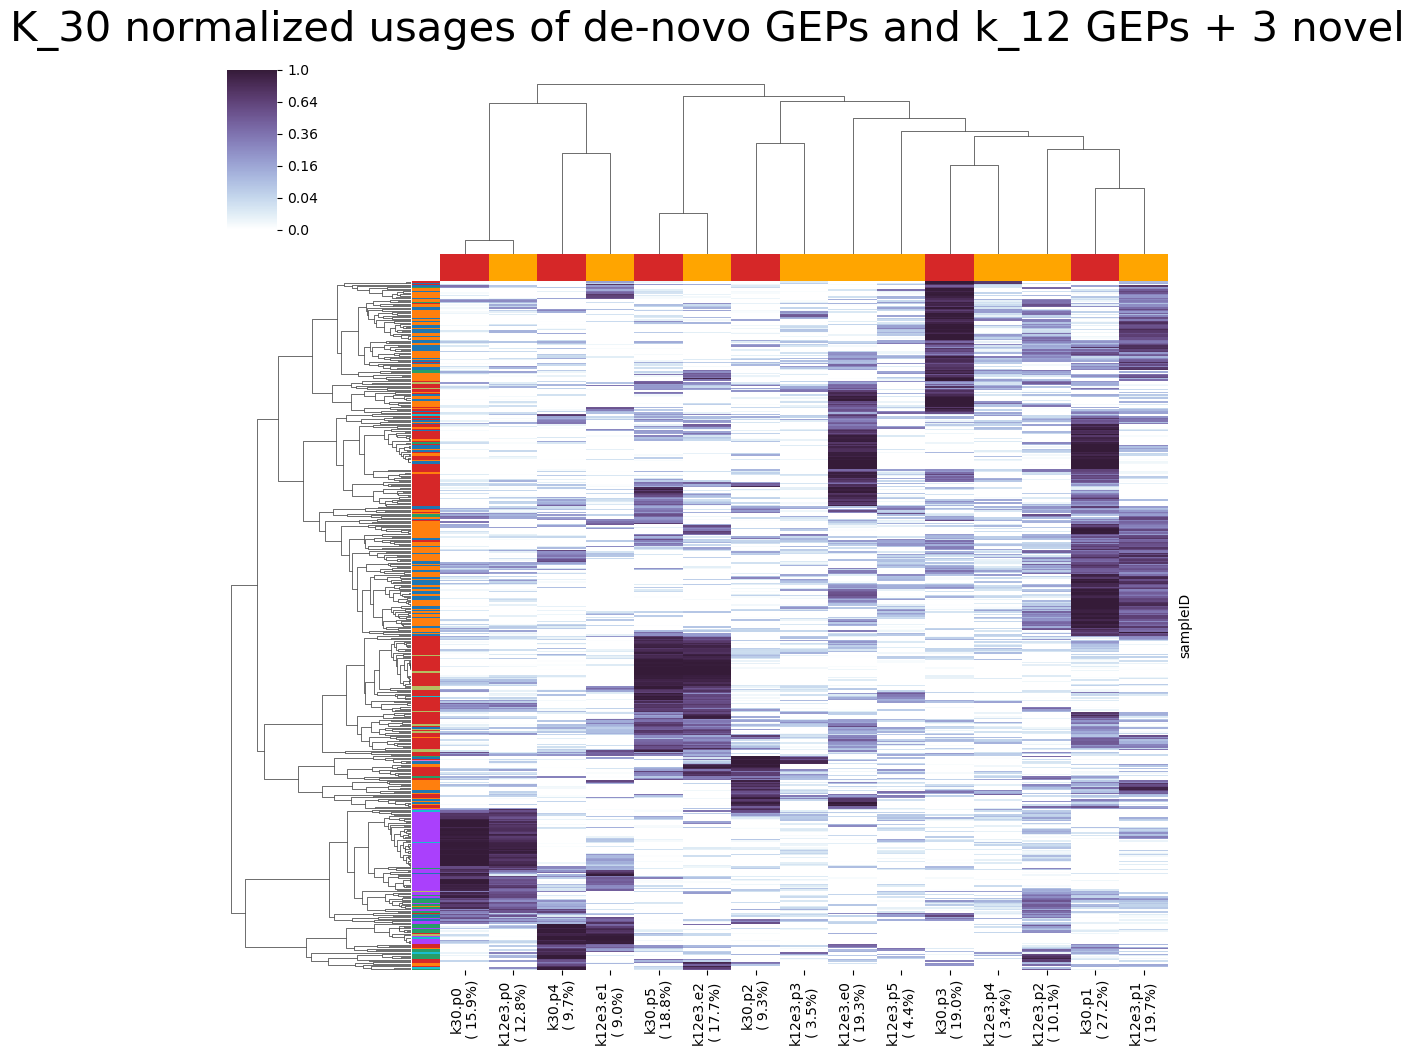

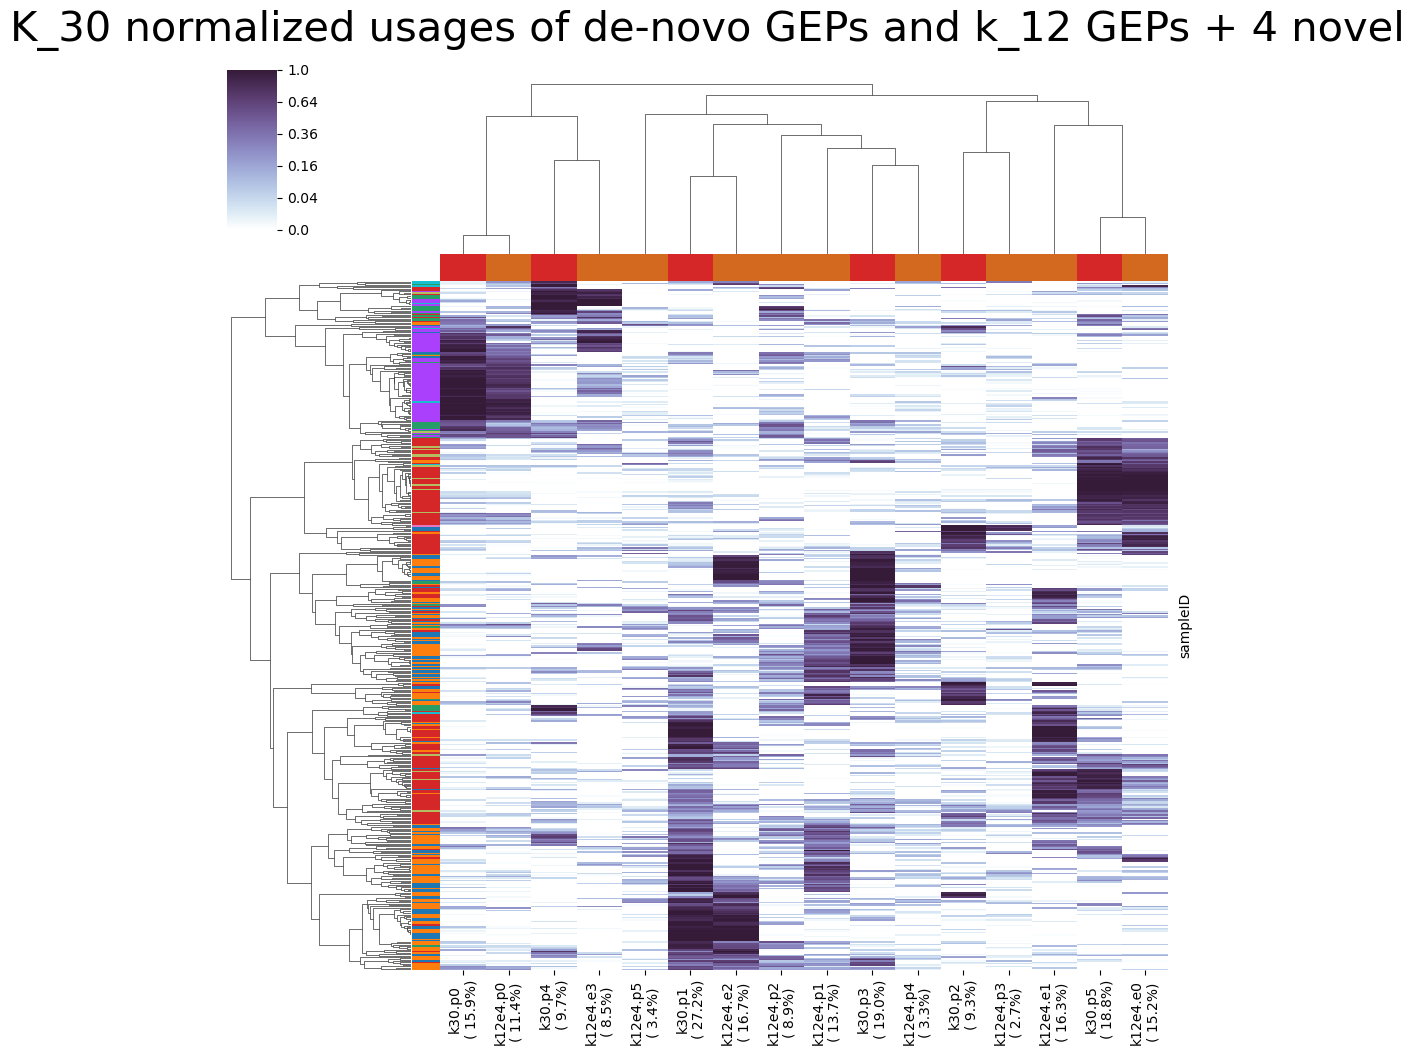

In [ ]:
dict_key0 = 'de_novo'
res_dict0 = pfnmf_results[dict_key0]

for dict_key1 in ['k12e1', 'k12e2', 'k12e3', 'k12e4']:
    res_dict1 = pfnmf_results[dict_key1]
    
    title = f'K_30 normalized usages of de-novo GEPs and k_12 GEPs + {res_dict1["rank"] - rank_k12} novel'

    joint_usages = np.concatenate([res_dict0['norm_usage'], res_dict1['norm_usage']], axis=1)

    joint_labels = res_dict0['prog_label_2l'] + res_dict1['prog_label_2l']

    joint_colors = [coloring_scheme[dict_key0]] * res_dict0['rank'] + [coloring_scheme[dict_key1]] * res_dict1['rank']

    un_sns = _utils.plot_usages_norm_clustermaps(k_30, normalized_usages=joint_usages, columns=joint_labels,
                                                 title=title, show=True, sns_clustermap_params={'col_colors': joint_colors})

apply the usages clustermap function

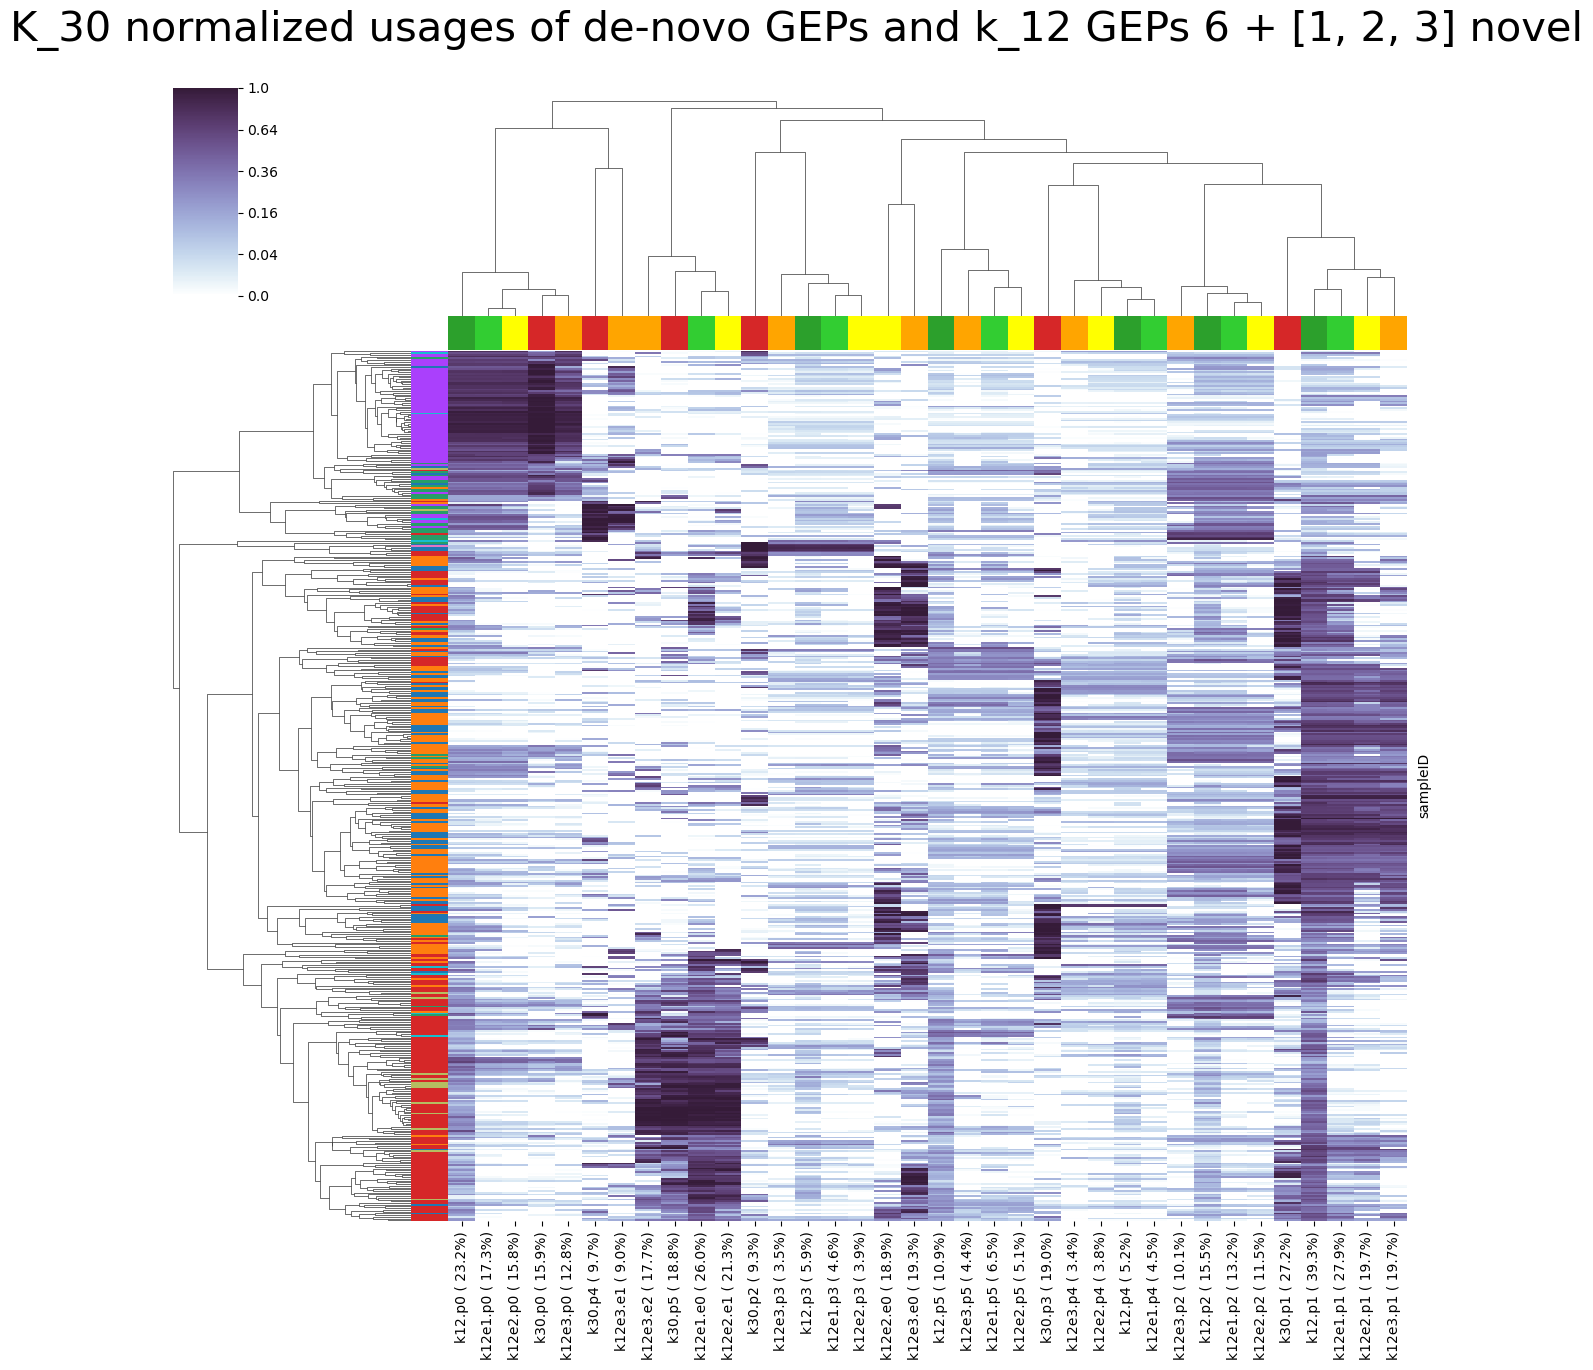

In [ ]:
title = f'K_30 normalized usages of de-novo GEPs and k_12 GEPs {rank_k12} + [1, 2, 3] novel'

dict_key0 = 'de_novo'
res_dict0 = pfnmf_results[dict_key0]

joint_usages = res_dict0['norm_usage'].copy()
joint_labels = res_dict0['prog_label_1l'].copy()
joint_colors = [coloring_scheme[dict_key0]] * res_dict0['rank']

for dict_key1 in ['k12', 'k12e1', 'k12e2', 'k12e3']:
    res_dict1 = pfnmf_results[dict_key1]
    
    joint_usages = np.concatenate([joint_usages, res_dict1['norm_usage']], axis=1)

    joint_labels.extend(res_dict1['prog_label_1l'])

    joint_colors.extend([coloring_scheme[dict_key1]] * res_dict1['rank'])

    
un_sns = _utils.plot_usages_norm_clustermaps(k_30, normalized_usages=joint_usages, columns=joint_labels, title=title,
                                             show=True, sns_clustermap_params={'col_colors': joint_colors, 'figsize': (13, 13)})

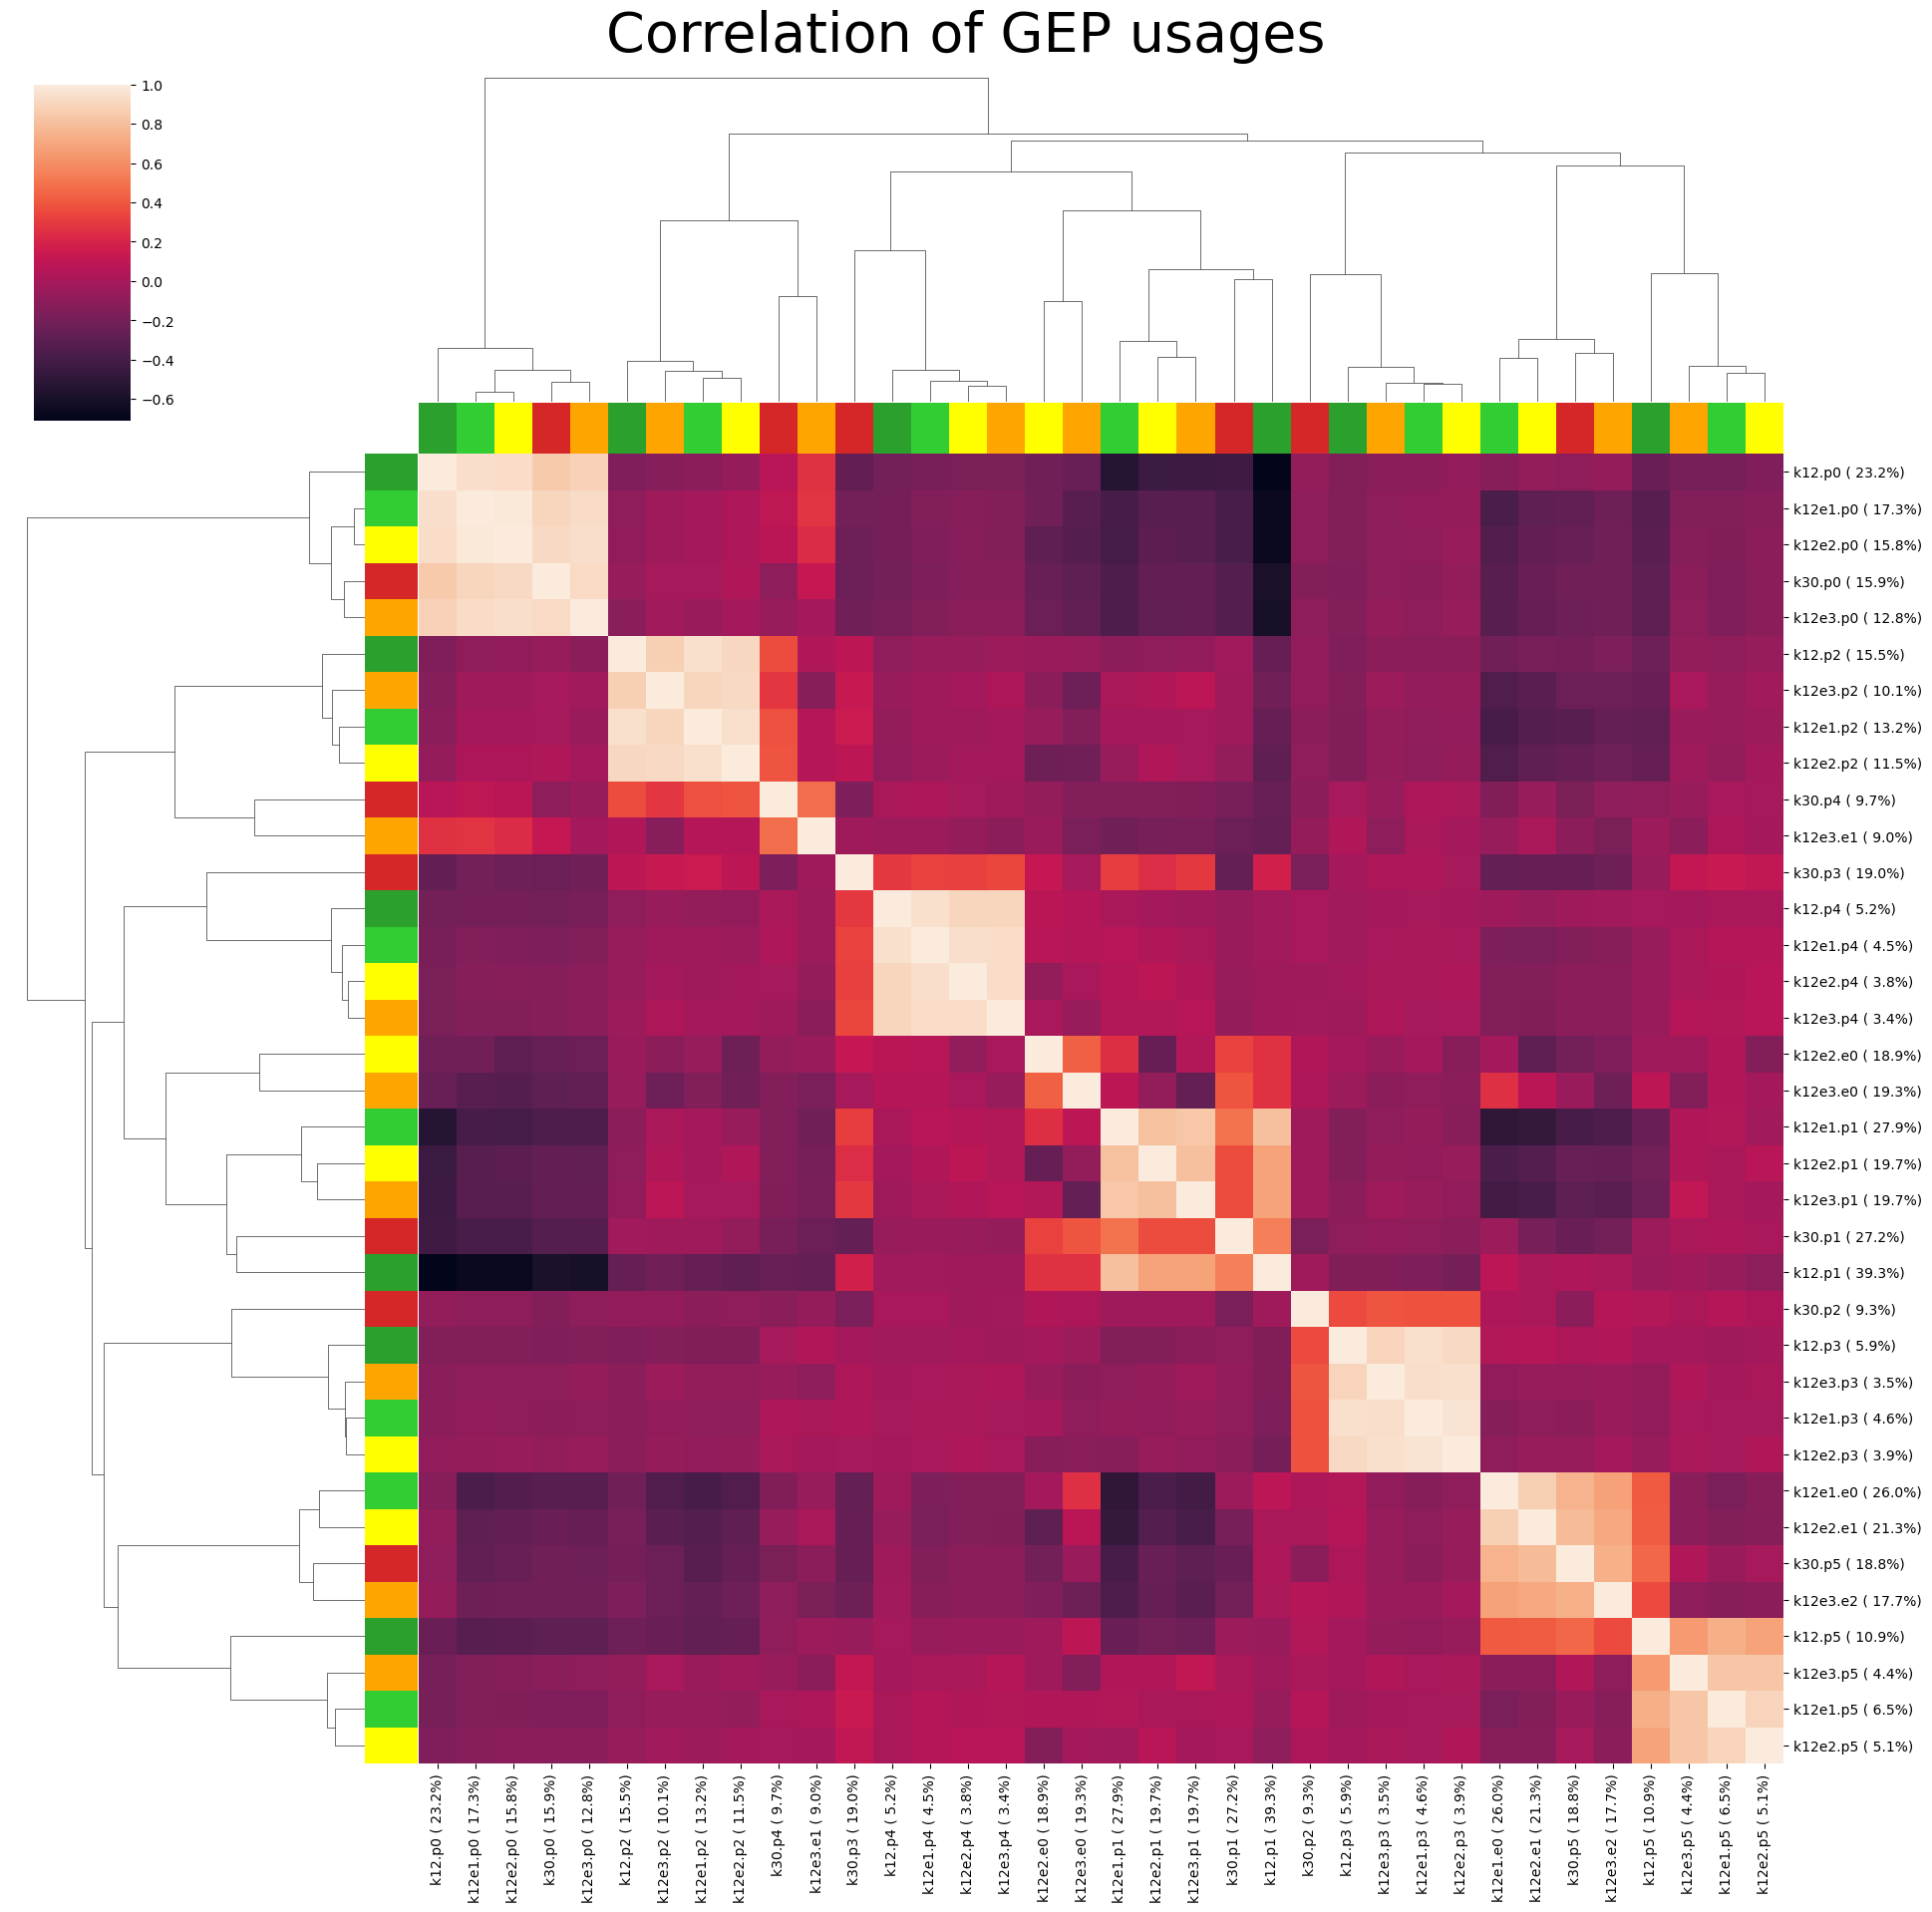

In [ ]:
n_programs = joint_usages.shape[1]

pearson_corr = np.corrcoef(joint_usages.T)

un_sns = _utils.sns.clustermap(pd.DataFrame(pearson_corr, index=joint_labels, columns=joint_labels),
                               figsize=(4 + n_programs * 0.43, 4 + n_programs * 0.41),
                               row_colors=joint_colors, col_colors=joint_colors)

un_sns.figure.suptitle('Correlation of GEP usages', fontsize=40, y=1.02)
plt.show()

### Extracting usage coefficients over all genes

In [ ]:
z_layer = 'cpm_log1p_zscore'

k_30.layers[z_layer] = sc.pp.normalize_total(k_30, target_sum=1e6, inplace=False)['X']
sc.pp.log1p(k_30, layer=z_layer)
sc.pp.scale(k_30, layer=z_layer)

In [ ]:
for dict_key in pfnmf_results.keys():
    res_dict = pfnmf_results[dict_key]
    
    res_dict['gene_coefs'] = pd.DataFrame(
        _utils.fastols(res_dict['norm_usage'], k_30.layers[z_layer]).T,
        index=k_30.var.index,
        columns=res_dict['prog_name'])

In [ ]:
res_dict['gene_coefs']

,k12e4.p0,k12e4.p1,k12e4.p2,k12e4.p3,k12e4.p4,k12e4.p5,k12e4.e0,k12e4.e1,k12e4.e2,k12e4.e3
geneID,,,,,,,,,,
ENSMUSG00000000001.4_Gnai3,0.499529,-0.169596,-0.124022,-0.151748,0.249595,-1.163477,0.392715,-0.033344,-0.539738,0.567924
ENSMUSG00000000028.14_Cdc45,-0.244290,-0.298000,0.085815,4.106797,-0.432468,0.000417,0.021283,-0.234783,-0.172790,0.339966
ENSMUSG00000000031.15_H19,-0.003291,0.309991,0.178088,-0.170543,0.013092,-0.414835,-0.058766,-0.041157,-0.091545,-0.105982
ENSMUSG00000000049.11_Apoh,-0.039562,-0.045673,-0.113404,-0.087131,-0.213779,-0.154253,-0.083824,0.386029,-0.056863,-0.062460
ENSMUSG00000000056.7_Narf,-0.121878,-0.076120,0.004819,0.035250,-0.090752,0.275277,0.070996,0.087169,-0.275152,0.445200
...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000114960.1_AC115289.2,0.094634,-0.059659,-0.216200,-0.247565,0.419844,0.009294,0.261511,-0.141519,-0.016549,-0.055359
ENSMUSG00000114967.1_AC161884.2,0.088354,0.040457,-0.032685,0.368224,-0.193495,-0.424446,0.166846,0.003314,-0.150555,-0.033004
ENSMUSG00000114968.1_AC130217.2,-0.166776,-0.111184,-0.168040,-0.057411,-0.270401,-0.109621,-0.083276,-0.086634,0.243469,0.581306


### Running GO

In [ ]:
gp = _utils.MyGProfiler(organism='hsapiens', sources=['GO:BP', 'WP', 'REAC', 'KEGG'])

genes_list = adata.var.loc[k_30.var.index, 'geneSymbol'].to_list()

In [ ]:
%%script --no-raise-error false

program_go_dir = _utils.set_dir(notebook_dir.joinpath('programs_GSEA'))

for dict_key in pfnmf_results.keys():
    res_dict = pfnmf_results[dict_key]
    
    for index in range(res_dict['rank']):
        ordered_genes_index = res_dict['gene_coefs'].nlargest(
            columns=[res_dict['prog_name'][index]],
            n=1000).index
        ordered_genes = adata.var.loc[ordered_genes_index, 'geneSymbol'].to_list()
        
        go_enrichment = gp.profile( 
            ordered_genes, ordered=True, background=genes_list)

        go_enrichment.to_csv(
            program_go_dir.joinpath(f"{res_dict['prog_name'][index]}.csv"))


In [41]:
joint_HVG_geneID = set(joint_K12_K30_var[joint_K12_K30_var.highly_variable].index)
k_30_HVG_geneID = set(k_30.var[k_30.var.highly_variable].index)
union_HVG_geneID = k_30_HVG_geneID.union(joint_HVG_geneID)

for dict_key in pfnmf_results.keys():
    res_dict = pfnmf_results[dict_key]
    for index in range(res_dict['rank']):
        
        
        ordered_geneID = set(res_dict['gene_coefs'].nlargest(
            columns=[res_dict['prog_name'][index]], n=1000).index)
        print(res_dict['prog_name'][index],
              len(set.intersection(ordered_geneID, joint_HVG_geneID)),
              len(set.intersection(ordered_geneID, k_30_HVG_geneID)),
              len(set.intersection(ordered_geneID, union_HVG_geneID))
             )

k30.p0 192 244 271
k30.p1 104 126 168
k30.p2 157 113 218
k30.p3 136 95 179
k30.p4 154 175 234
k30.p5 88 128 141
k12.p0 185 235 260
k12.p1 74 118 141
k12.p2 126 150 191
k12.p3 126 126 202
k12.p4 151 109 201
k12.p5 86 112 132
k12e1.p0 190 242 268
k12e1.p1 81 128 156
k12e1.p2 124 142 183
k12e1.p3 127 128 205
k12e1.p4 155 115 208
k12e1.p5 74 59 110
k12e1.e0 93 134 148
k12e2.p0 189 242 268
k12e2.p1 79 112 140
k12e2.p2 127 147 190
k12e2.p3 128 128 206
k12e2.p4 156 116 209
k12e2.p5 69 48 94
k12e2.e0 129 103 168
k12e2.e1 89 126 139
k12e3.p0 184 232 259
k12e3.p1 79 113 142
k12e3.p2 125 137 180
k12e3.p3 130 130 209
k12e3.p4 155 120 211
k12e3.p5 75 56 105
k12e3.e0 120 124 175
k12e3.e1 142 157 210
k12e3.e2 97 130 152
k12e4.p0 177 222 248
k12e4.p1 79 107 141
k12e4.p2 124 134 178
k12e4.p3 137 132 218
k12e4.p4 159 124 215
k12e4.p5 78 57 110
k12e4.e0 106 135 161
k12e4.e1 106 110 152
k12e4.e2 115 96 161
k12e4.e3 170 221 259


In [185]:
# %%script --no-raise-error false

program_go_dir = _utils.set_dir(notebook_dir.joinpath('programs_GSEA_HVG'))

for dict_key in pfnmf_results.keys():
    res_dict = pfnmf_results[dict_key]
    
    for index in range(res_dict['rank']):
        ordered_genes_index = res_dict['gene_coefs'].nlargest(
            columns=[res_dict['prog_name'][index]],
            n=1000).index
        
        ordered_genes_index = ordered_genes_index[ordered_genes_index.isin(joint_HVG_geneID)]
        
        ordered_genes = adata.var.loc[ordered_genes_index, 'geneSymbol'].to_list()
        
        go_enrichment = gp.profile( 
            ordered_genes, ordered=True, background=genes_list)

        go_enrichment.to_csv(
            program_go_dir.joinpath(f"{res_dict['prog_name'][index]}.csv"))
        
#         break
#     break
# go_enrichment

### Calculating truncated spearman correlation


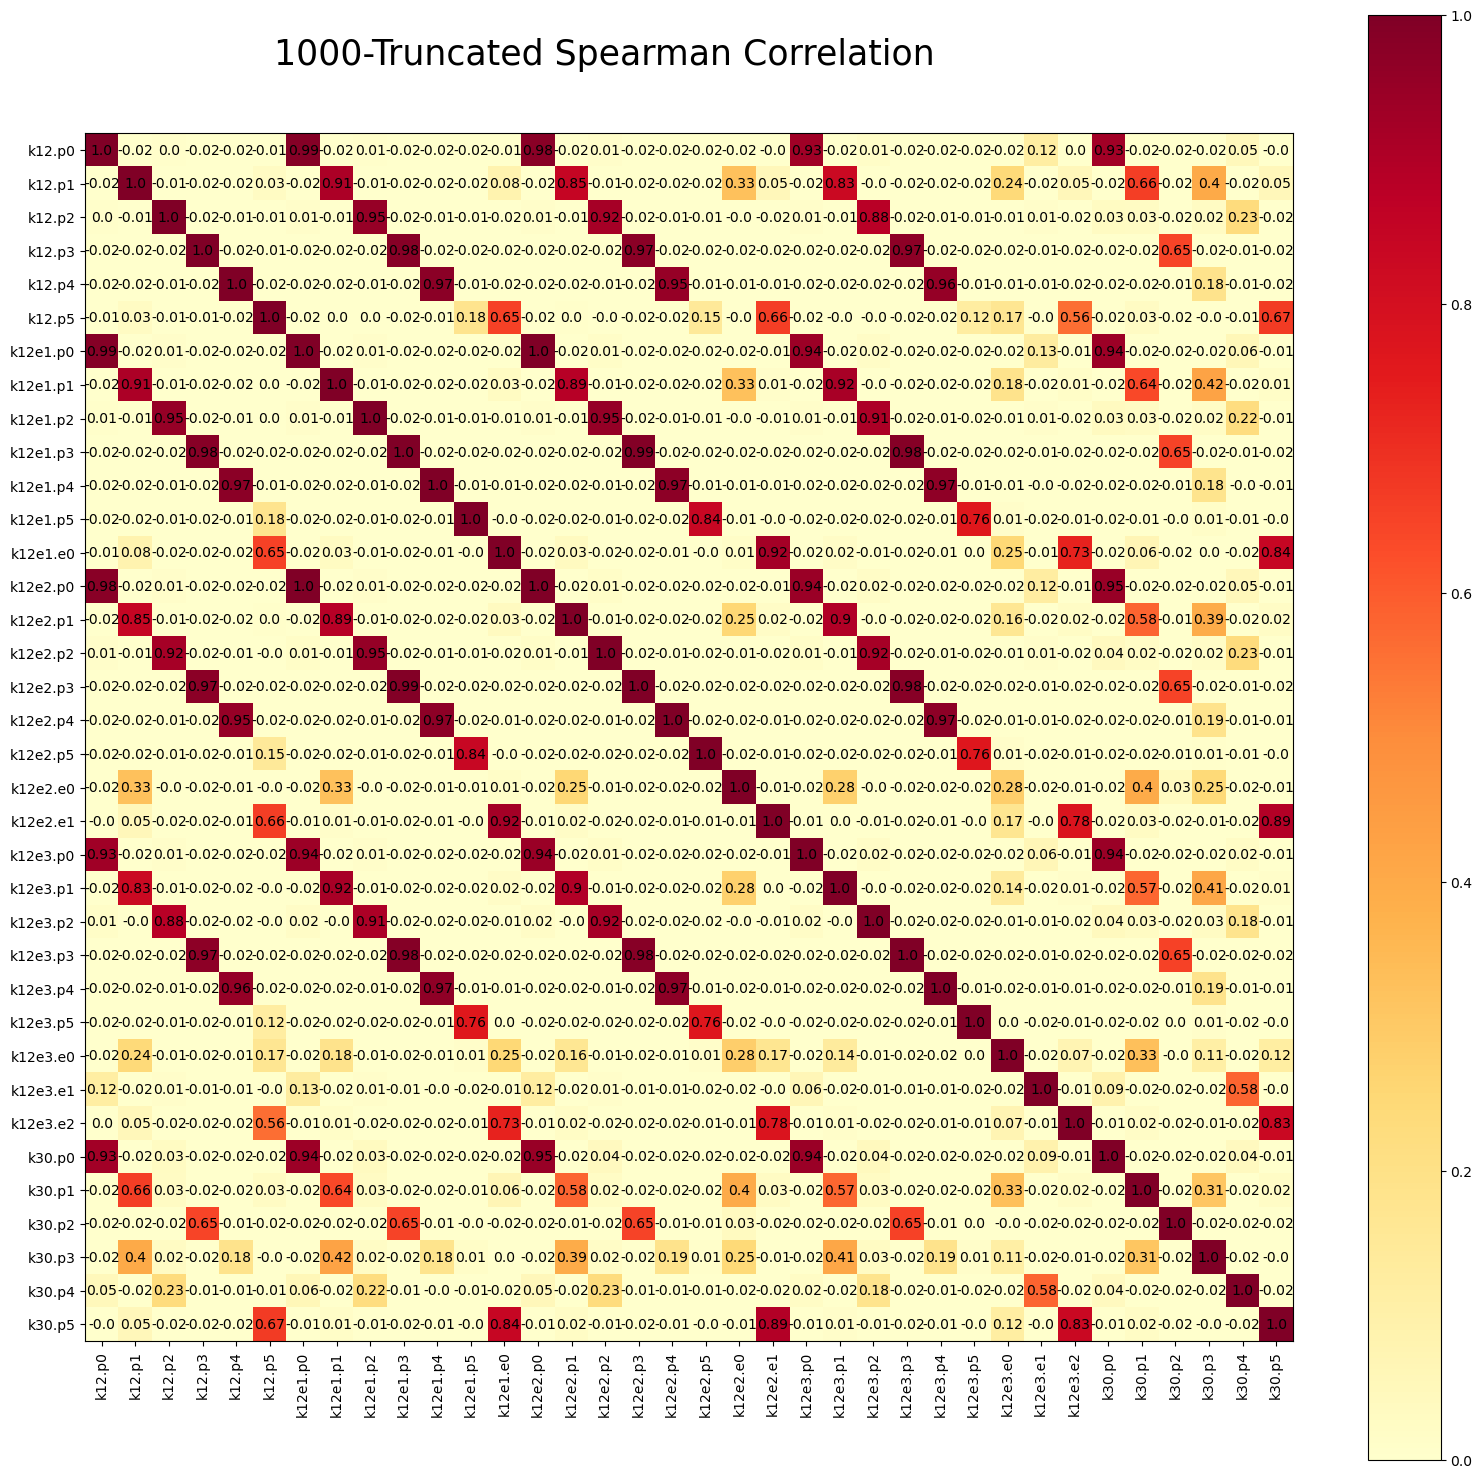

In [154]:
keys = ['k12', 'k12e1', 'k12e2', 'k12e3', 'de_novo']

concatenated_spectras = pd.concat([
    pfnmf_results[dict_key]['gene_coefs'].copy() for dict_key in keys], axis=1)

n_genes, n_programs = concatenated_spectras.shape


ranked_coefs = n_genes - rankdata(concatenated_spectras, axis=0)

ranked_coefs[ranked_coefs > _constants.N_COMPARED_RANKED] = _constants.N_COMPARED_RANKED

spearman_corr = np.corrcoef(ranked_coefs, rowvar=False)

# spearman figure
fig, ax = plt.subplots(figsize=(4 + ranked_coefs.shape[1] * 0.43,
                                4 + ranked_coefs.shape[1] * 0.41))

_utils.heatmap_with_numbers(
    spearman_corr, ax=ax, param_dict={'vmin': 0, 'vmax': 1})

ax.xaxis.tick_bottom()
ax.set_xticklabels(concatenated_spectras.columns, rotation='vertical')
ax.set_yticklabels(concatenated_spectras.columns)
ax.set_title(f'{_constants.N_COMPARED_RANKED}-Truncated Spearman Correlation',
             size=25, y=1.05, x=0.43)

plt.show(fig)

# fig.savefig(RESULTS_DIR.joinpath(
#     f'correlation_spearman_{utils.N_COMPARED_RANKED}_truncated.png'),
#     dpi=180, bbox_inches='tight')

# plt.close(fig)

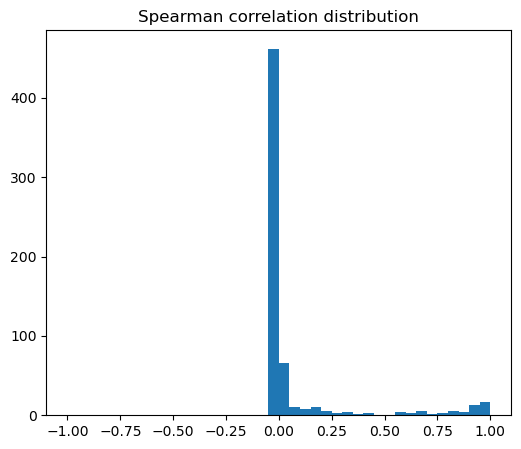

In [155]:
# correlation histogram
fig, ax = plt.subplots(figsize=(6, 5))

plt.hist(spearman_corr[np.triu_indices_from(spearman_corr, k=1)],
         bins=np.linspace(-1, 1, 41))
ax.set_title('Spearman correlation distribution')
plt.show()

# fig.savefig(RESULTS_DIR.joinpath('correlation_histogtam_pearson.png'),
#             dpi=180, bbox_inches='tight')

# plt.close(fig)

Number of edges=70


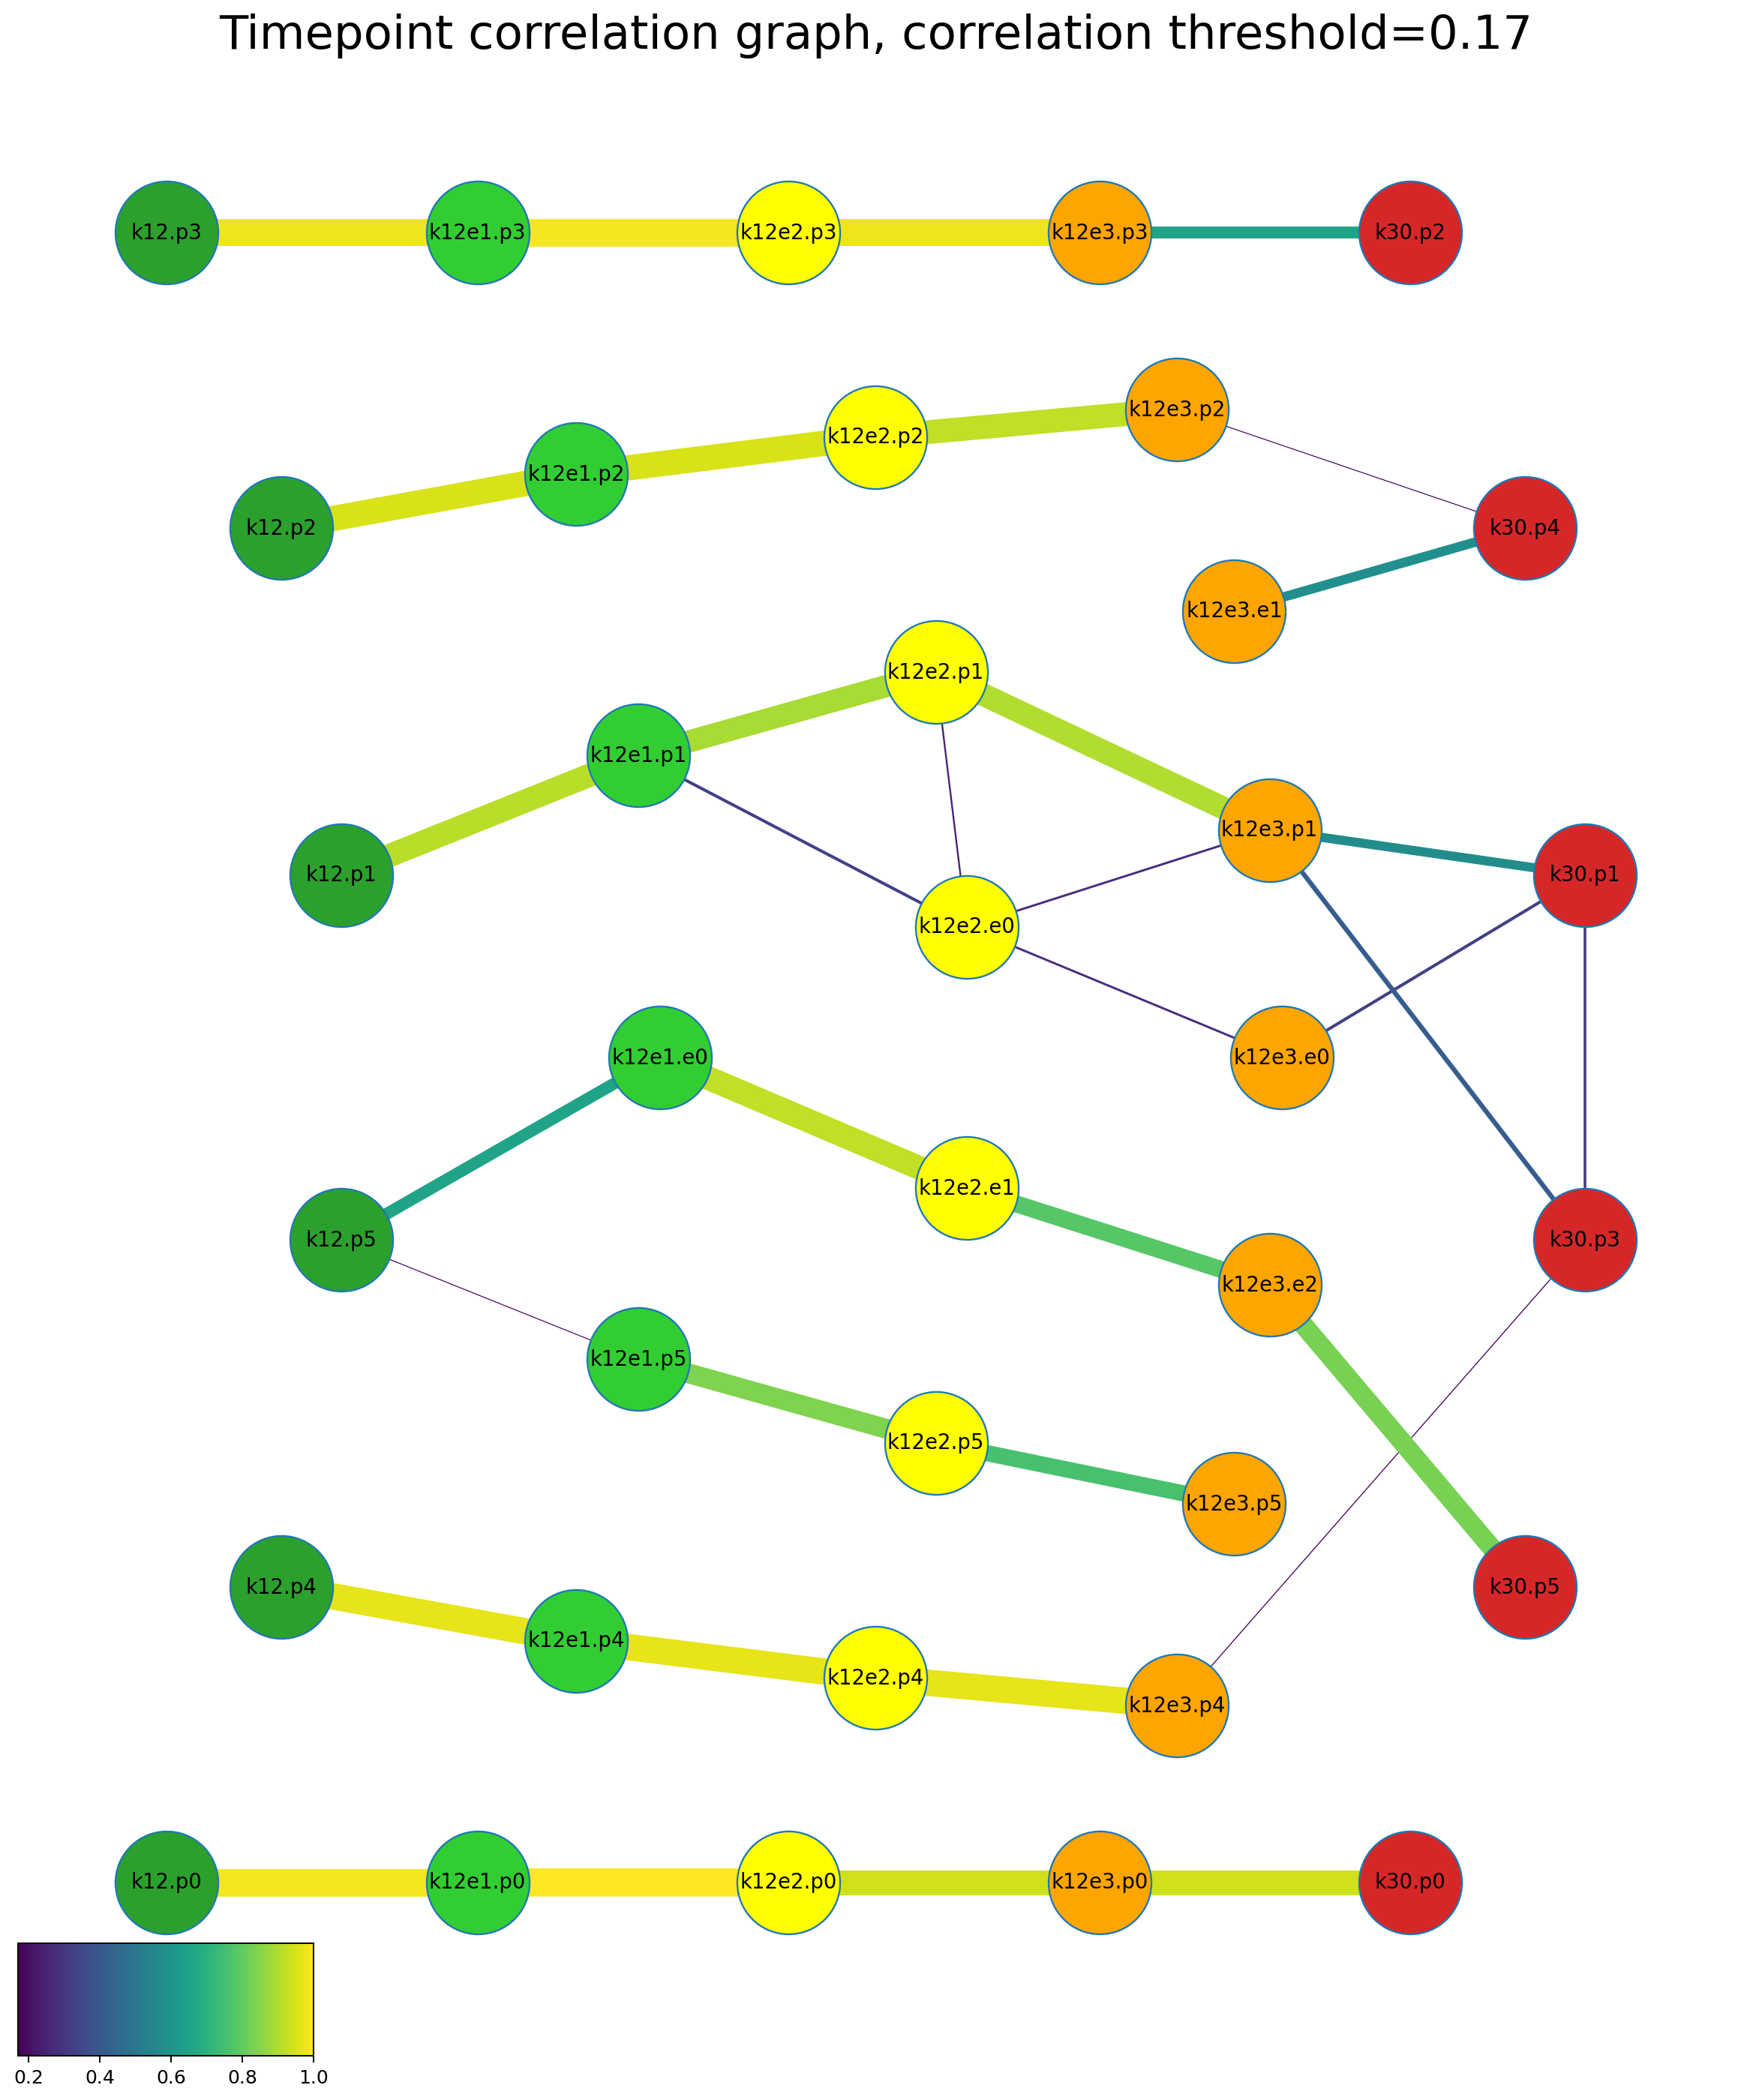

In [158]:
threshold = 0.17

# maping adata short name to layer number
name_map = dict(zip(keys, range(len(keys))))
name_map.update({'k30': name_map.pop('de_novo')})  # for the de_novo
ks = [pfnmf_results[key]['rank'] for key in keys]

# adjacency matrix creation and filtering
adj_df = pd.DataFrame(np.round((spearman_corr), 2),
                      index=concatenated_spectras.columns,
                      columns=concatenated_spectras.columns)

# order
linkage = hierarchy.linkage(
    adj_df, method='average', metric='euclidean')
prog_order = hierarchy.leaves_list(
    hierarchy.optimal_leaf_ordering(linkage, adj_df))

np.fill_diagonal(adj_df.values, 0)
# adj_df.values[adj_df.values <= 0.0] = 0

# keeping only edges between consecutive layers
for i in range(len(ks) - 2):
    adj_df.values[:np.sum(ks[:i + 1]), np.sum(ks[:i + 2]):] = 0
    adj_df.values[np.sum(ks[:i + 2]):, :np.sum(ks[:i + 1])] = 0

adj_df.values[adj_df.values <= threshold] = 0
print(f'Number of edges={np.count_nonzero(adj_df)}')

# ordering the nodes for display
adj_df = adj_df.iloc[prog_order, prog_order]

# create the graph object
G = nx.from_numpy_array(adj_df.values, create_using=nx.Graph)
nx.relabel_nodes(G, lambda i: adj_df.index[i], copy=False)
nx.set_node_attributes(
    G, {node: name_map[node.split('.')[0]] for node in G.nodes}, name='layer')

# prepare graph for display
layout = nx.multipartite_layout(G, subset_key='layer')

edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
edge_width = 15 * np.power(weights, 2)  # visual edge emphesis


for layer in {data['layer'] for key, data in G.nodes.data()}:
    nodes = [node for node in G.nodes if name_map[node.split('.')[0]] == layer]

    angles = np.linspace(-np.pi / 4, np.pi / 4, len(nodes))
    
    for i, node in enumerate(nodes):
        layout[node] = [layer + 2 * np.cos(angles[i]), np.sin(angles[i])]

fig, ax = plt.subplots(1, 1, figsize=(16.4, 19.2), dpi=180)
nx.draw(G, layout, node_size=3000, with_labels=False, edge_color=weights,
        edge_vmin=threshold, edge_vmax=1., width=edge_width, ax=ax)

cmp = plt.matplotlib.cm.ScalarMappable(plt.matplotlib.colors.Normalize(vmin=threshold, vmax=1))
plt.colorbar(cmp, orientation='horizontal', cax=fig.add_subplot(15, 5, 71))

# change color of layers
for key in keys:
    nx.draw_networkx_nodes(
        G, layout, node_color=coloring_scheme[key], node_size=2800,
        nodelist=pfnmf_results[key]['prog_name'], ax=ax)
nx.draw_networkx_labels(G, layout, font_size=11, ax=ax)

ax.set_title(f'Timepoint correlation graph, correlation threshold={threshold}',
             {'fontsize': 25})
plt.show()

<module 'matplotlib' from '/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/matplotlib/__init__.py'>